# coil scan analysis

In [19]:
from matplotlib import pyplot as plt
import csv
import numpy as np
import os
import PIL # for reading tif images
import h5py

def get_max_idx(data):
    """return max value and corresponding index for 1d data"""
    maxdat = 0
    maxidx = 0
    for i,dat in enumerate(data):
        if dat > maxdat:
            maxdat = dat
            maxidx = i
    return maxdat, maxidx

expdir = "C:\\Networking Experiment\\artiq codes\\artiq-master\\repository\\qn_artiq_routines\\analysis\\csv_data\\"
results = 'C:\\Networking Experiment\\artiq codes\\artiq-master\\results\\'

## Tiff analysis

### Todo. For now, see C:\Users\QC\OneDrive - UW-Madison\Documents\Mathematica\tif_analysis

For analyzing the spooled images we take during the coil scans to verify the MOT still loads with the default settings, 
as of 2023/05/16.

In [21]:
tif_file = os.path.join(expdir, "results\\2023-05-16\\20\\MOTScanCheck.tif")
im_array = np.array(PIL.Image.open(tif_file))

In [23]:
im_array.shape

(281, 281)

In [24]:
PIL.Image.open?

TypeError: Invalid shape (281,) for image data

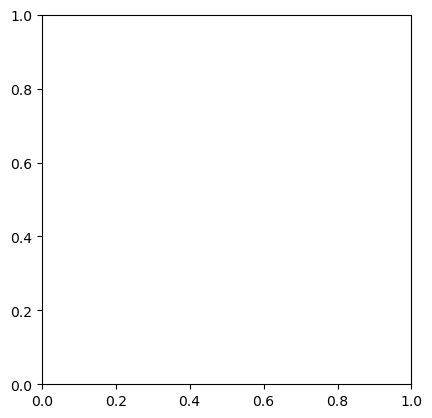

In [10]:
for im in im_data:
    plt.imshow(im)
    plt.show()

## CSV Analysis

### September 2023

In [37]:
f = h5py.File(os.path.join(results, '2023-09-06\\17\\000005041-CoilScanSPCMCount.h5'))
[x for x in f['datasets'].values()]

[<HDF5 dataset "AOM_A1_power": shape (), type "<f8">,
 <HDF5 dataset "AOM_A2_power": shape (), type "<f8">,
 <HDF5 dataset "AOM_A3_power": shape (), type "<f8">,
 <HDF5 dataset "AOM_A4_power": shape (), type "<f8">,
 <HDF5 dataset "AOM_A5_power": shape (), type "<f8">,
 <HDF5 dataset "AOM_A6_power": shape (), type "<f8">,
 <HDF5 dataset "FORT_monitor": shape (675,), type "<f8">,
 <HDF5 dataset "MOT1_monitor": shape (675,), type "<f8">,
 <HDF5 dataset "MOT2_monitor": shape (675,), type "<f8">,
 <HDF5 dataset "MOT3_monitor": shape (675,), type "<f8">,
 <HDF5 dataset "MOT4_monitor": shape (675,), type "<f8">,
 <HDF5 dataset "MOT5_monitor": shape (675,), type "<f8">,
 <HDF5 dataset "MOT6_monitor": shape (675,), type "<f8">,
 <HDF5 dataset "MOT_switchyard_monitor": shape (675,), type "<f8">,
 <HDF5 dataset "Vx_array": shape (), type "|O">,
 <HDF5 dataset "Vy_array": shape (), type "|O">,
 <HDF5 dataset "Vz_bottom_array": shape (), type "|O">,
 <HDF5 dataset "Vz_top_array": shape (), type "|

In [38]:
MOTdata = [np.array(data) for data in  f['datasets'].values()][7:14]

In [44]:
datafile = os.path.join(expdir,"20230906_173637_coil_scan.csv")
t_exp = 0.3 # the SPCM exposure time in seconds. 

has_header = True
with open(datafile, 'r', newline='') as f:
    reader = csv.reader(f)
    if has_header:
        header = reader.__next__()
    data = [row for row in reader]#[:5]
    f.close()

data = np.array(data,float).transpose()
# print(data)
rows,cols = data.shape

In [46]:
counts = data[0]/t_exp # data is total counts in the exposure time. data/t_exp is the rate.
pd_data = data[-1] # the cooling laser power monitor
coil_data = data[1:-1]#[:12800] # just as a check. should make two figures

zbottom_data, ztop_data, xdata, ydata = coil_data

zbottom_steps = len(list(set(zbottom_data)))
ztop_steps = len(list(set(zbottom_data)))
xsteps = len(list(set(xdata)))
ysteps = len(list(set(ydata)))

steps = range(len(counts))

In [23]:
### nrows and ncols are the number of subplots in each image
nrows = 4
ncols = 5
assert nrows * ncols == zbottom_steps, f"the number of subplots should be zbottom_steps={zbottom_steps}"

In [24]:
k = l = 0
ysteps*xsteps*zbottom_steps*k + l*ysteps*xsteps
xsteps*ysteps

49

19600

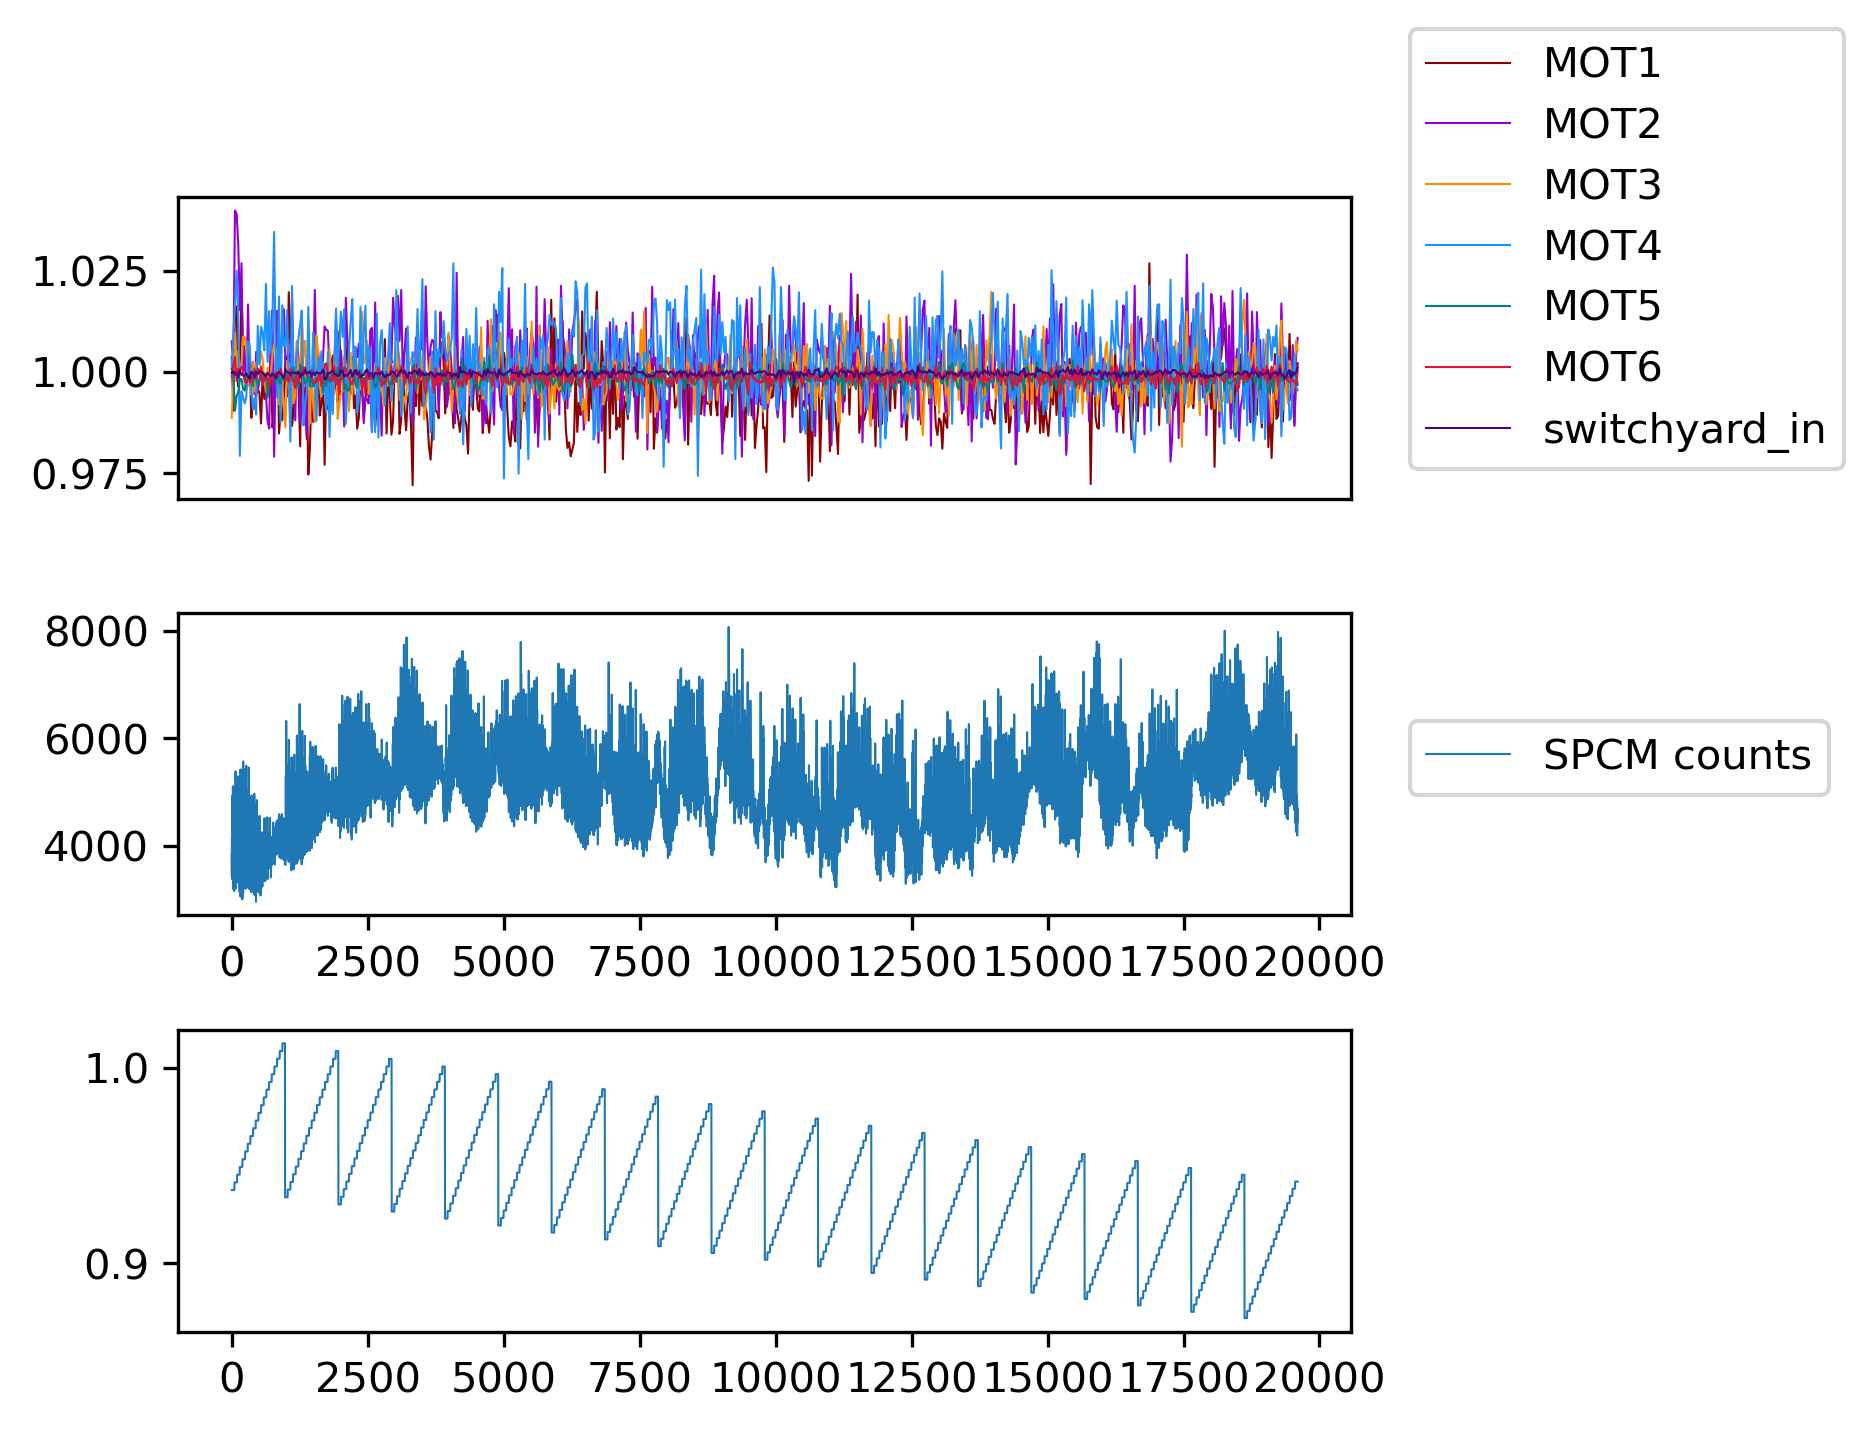

In [60]:
labels = [f'MOT{i+1}' for i in range(6)]+['switchyard_in']
fig,axes = plt.subplots(nrows=3,dpi=300)
ax, ax2, ax3 = axes
colors = ['darkred','darkviolet','darkorange','dodgerblue','teal','crimson','indigo']
for label,data,color in zip(labels,MOTdata,colors):
    ypts = data[20:] # the feedback runs 20 times before we start counting photons
    xpts = range(len(ypts))
#     ax.scatter(xpts, ypts, color=color,s=0.1)
    ax.plot(xpts, ypts, color=color, label=label,linewidth=0.5)
#     ax.set_ylim((0.95,1.05))
    ax.legend(loc=(1.05,0.1))
ax.get_xaxis().set_visible(False)
ax2.plot(steps,counts,label='SPCM counts',linewidth=0.5)
ax3.plot(steps,zbottom_data/ztop_data,label='VZ_bottom/Vz_top',linewidth=0.5)
# plt.gcf().autofmt_xdate()
ax2.legend(loc=(1.05,0.4))
ax4.legend(loc=(1.05,0.4))
fig.tight_layout()

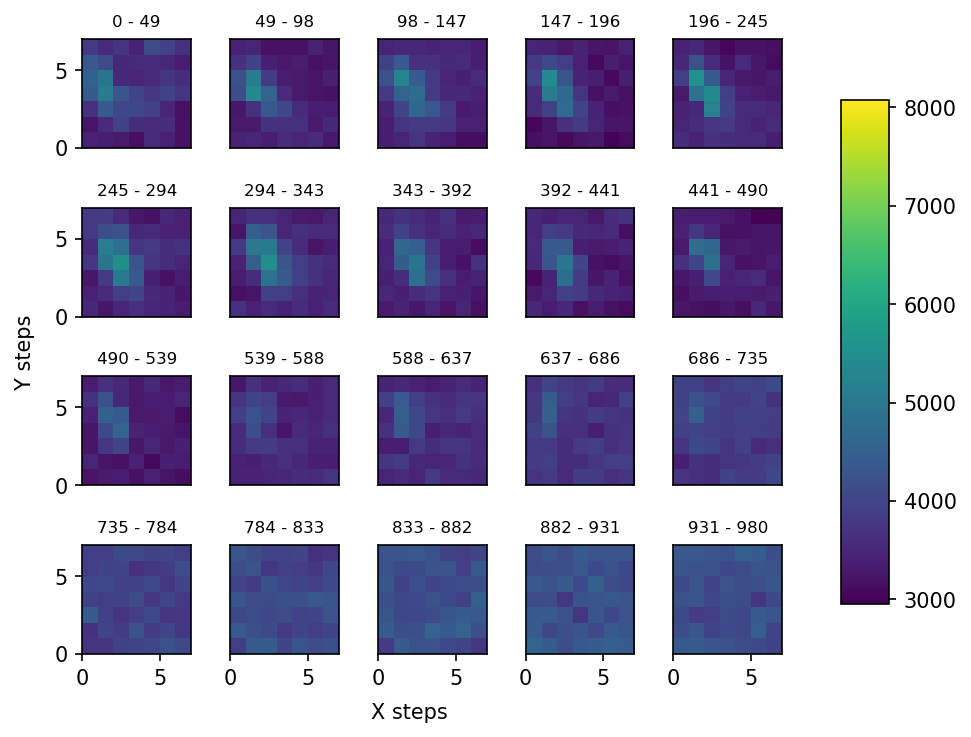

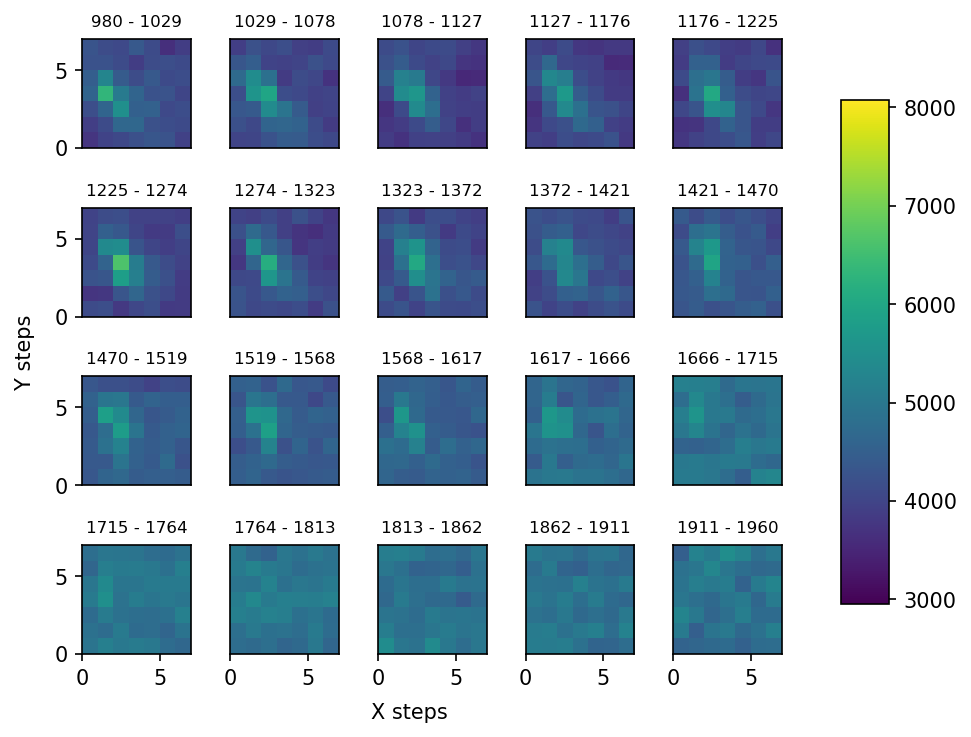

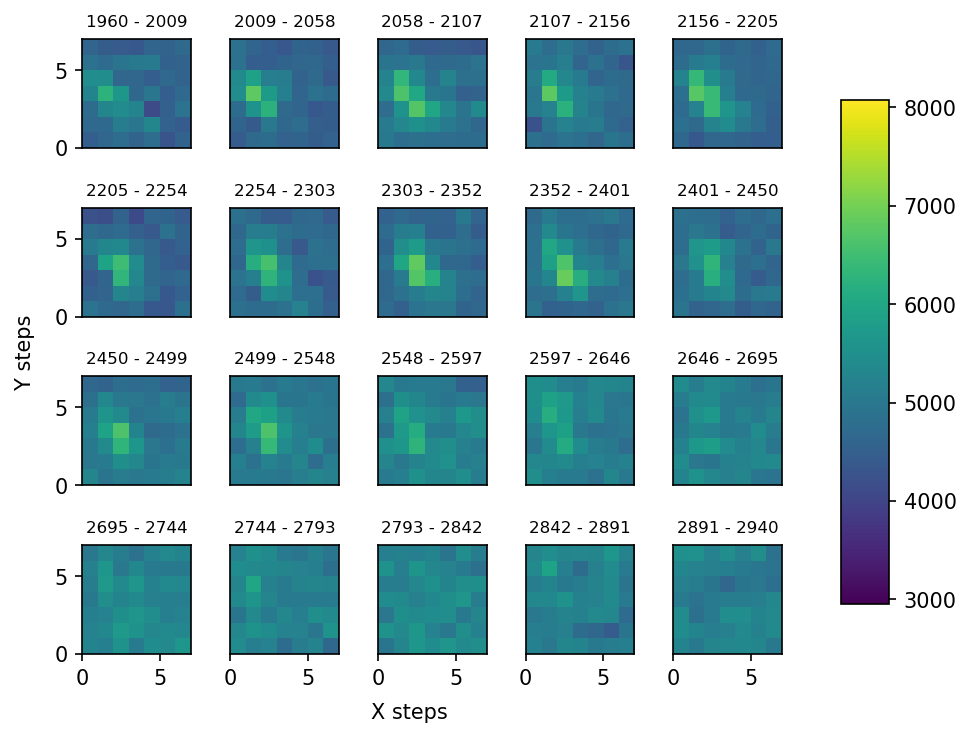

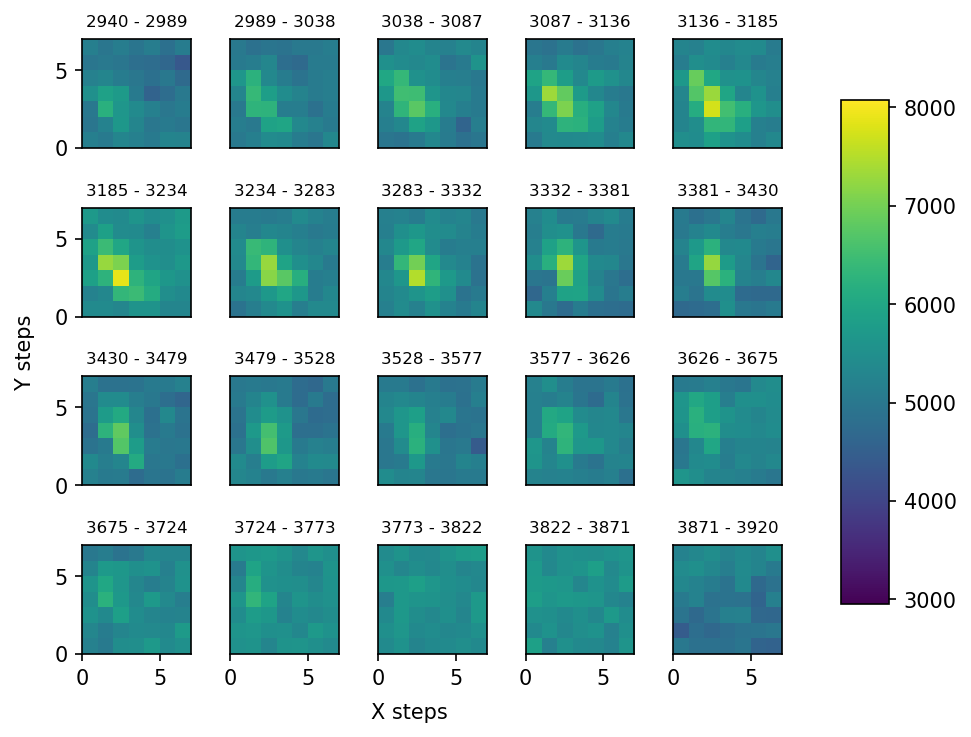

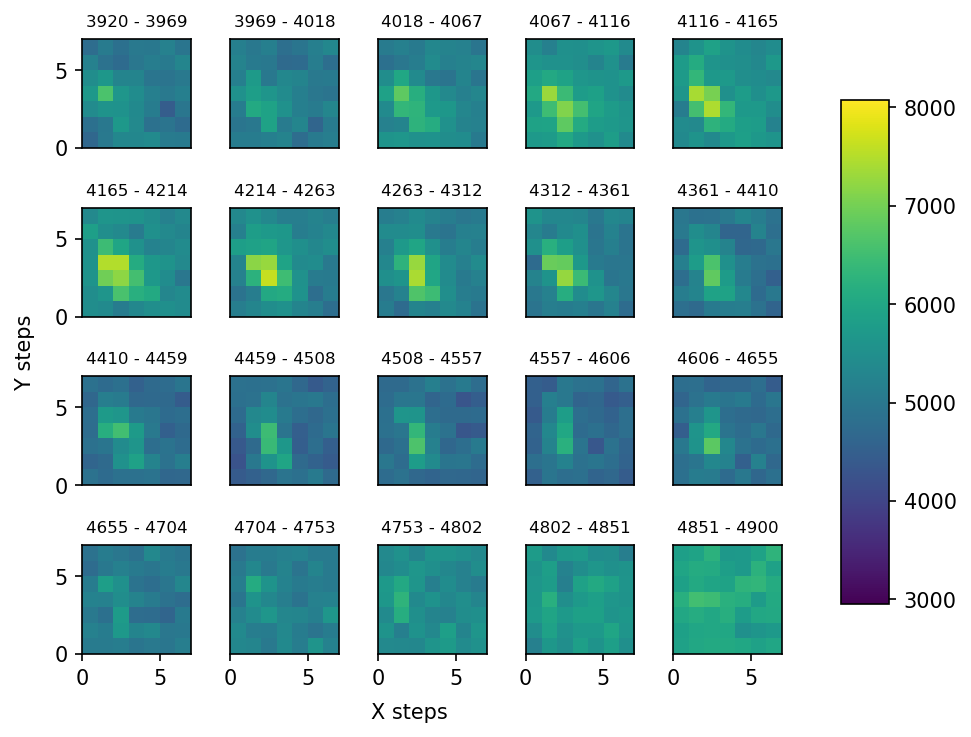

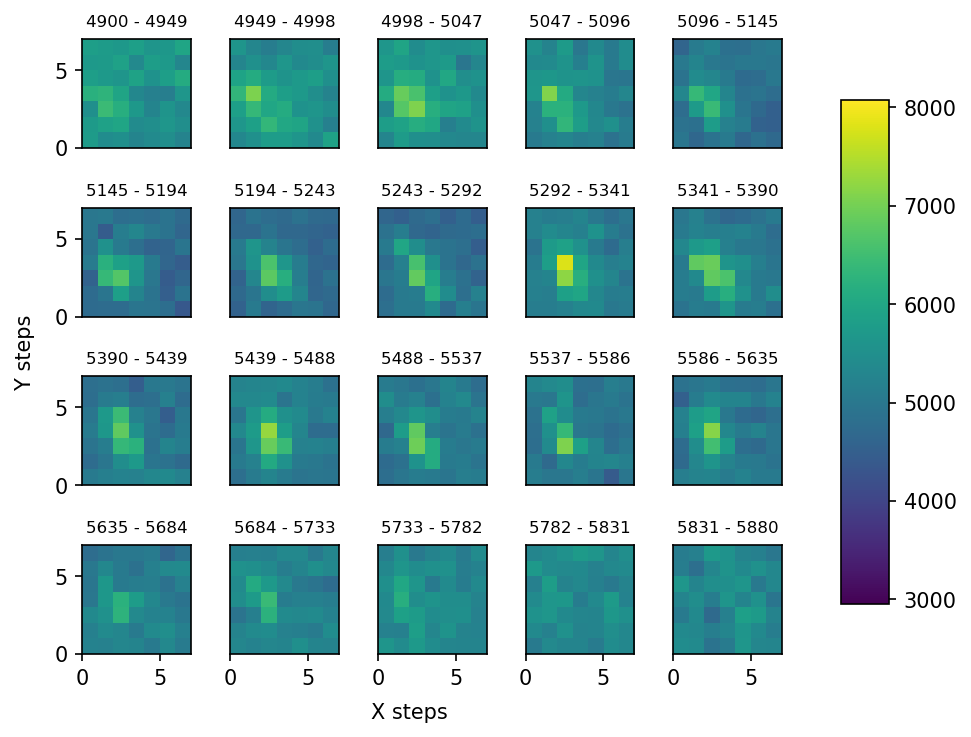

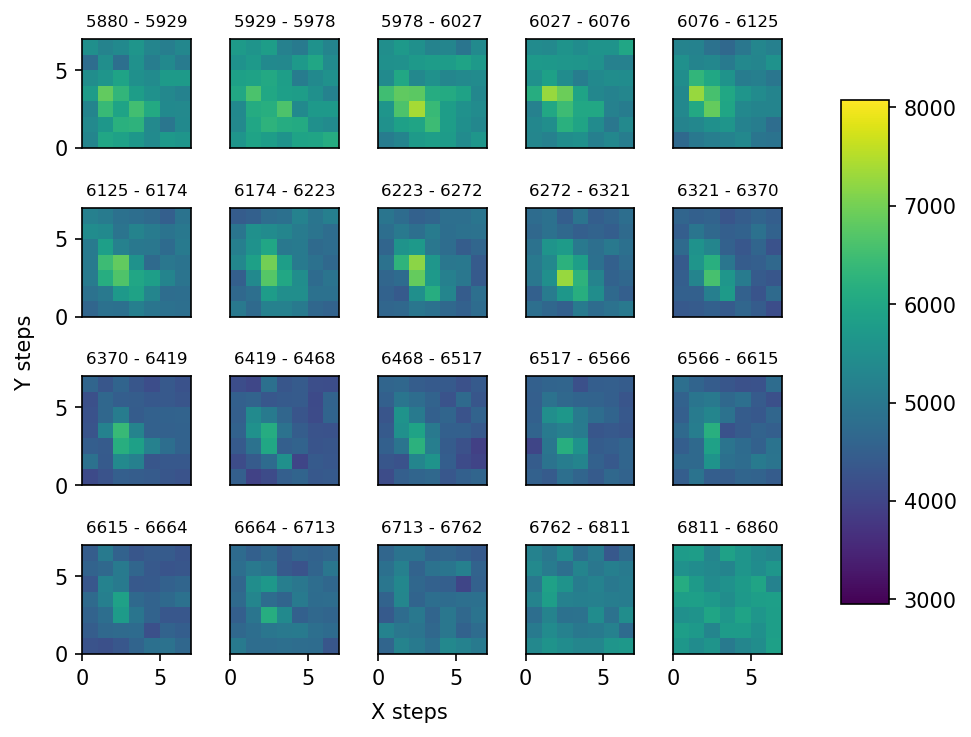

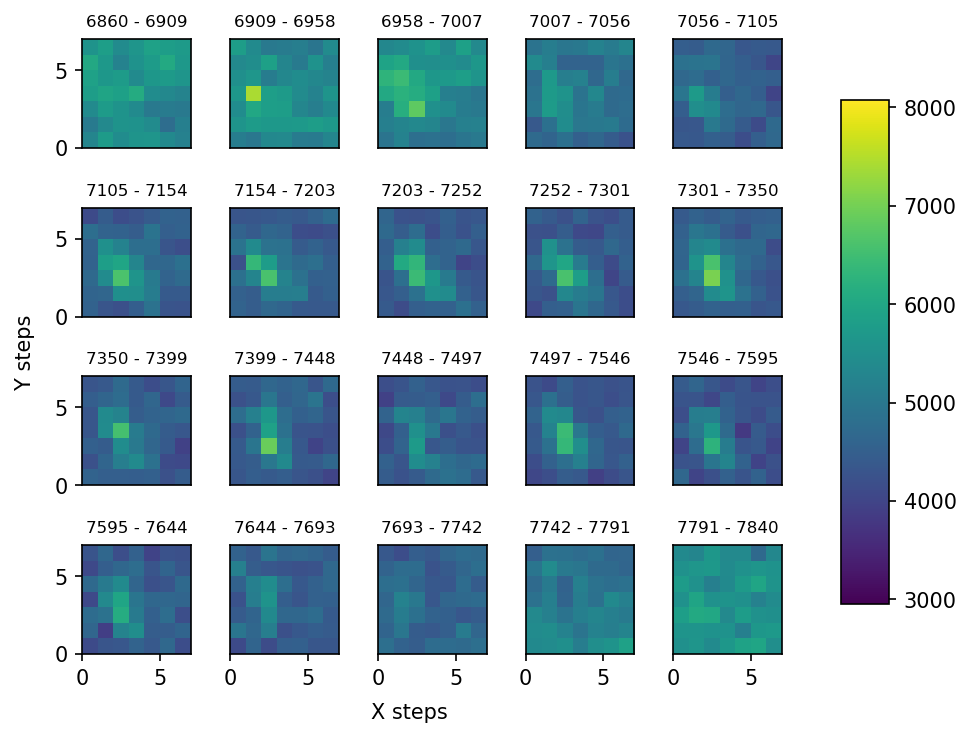

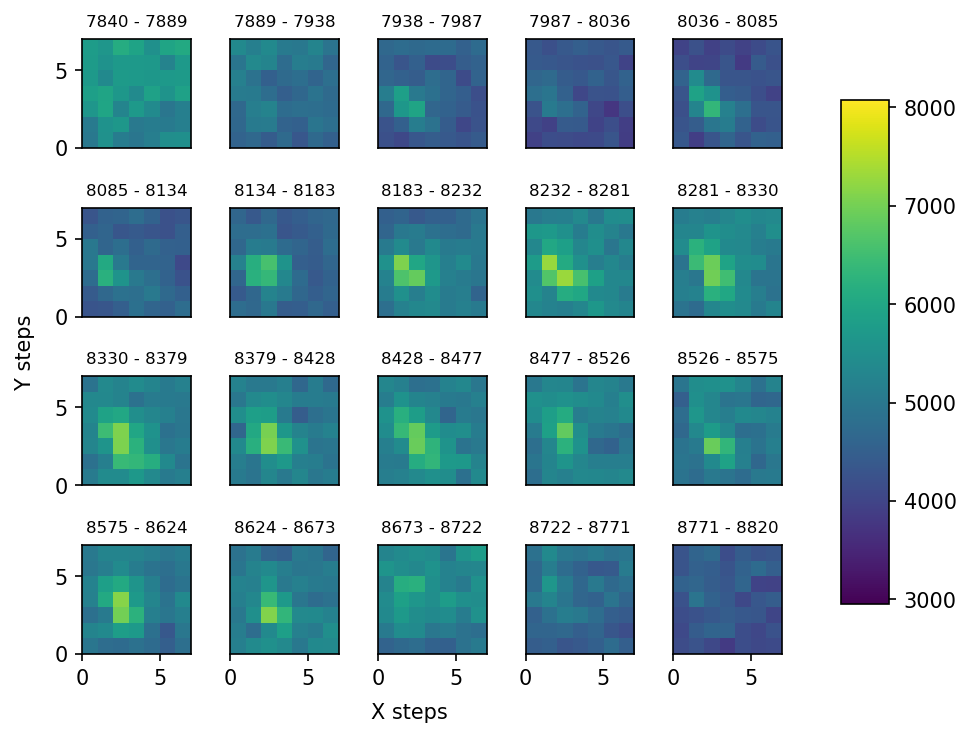

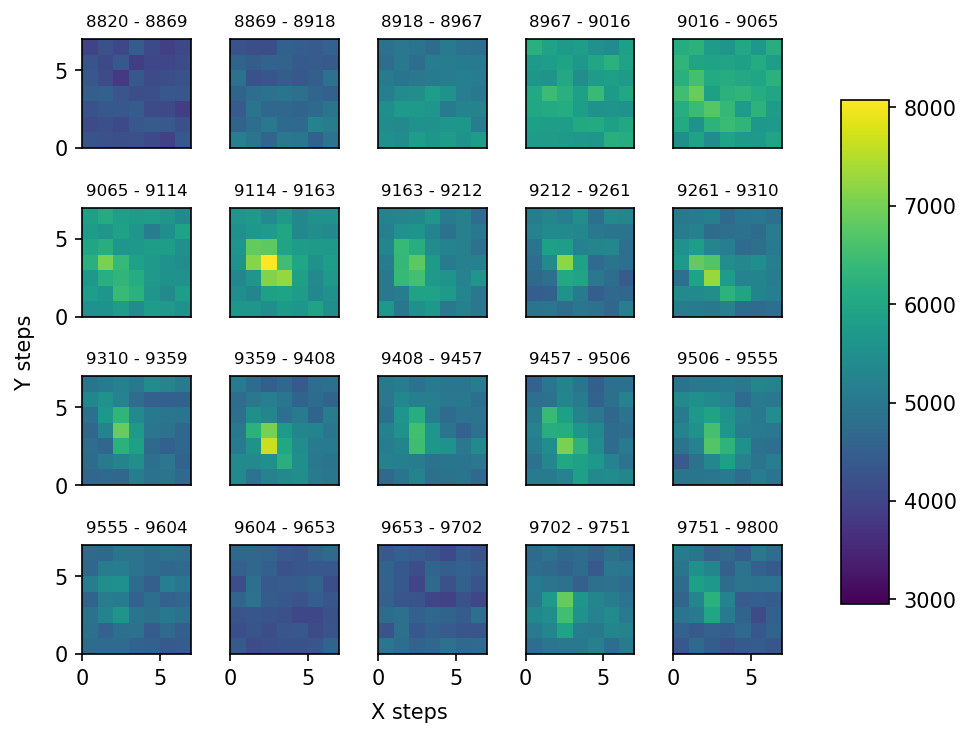

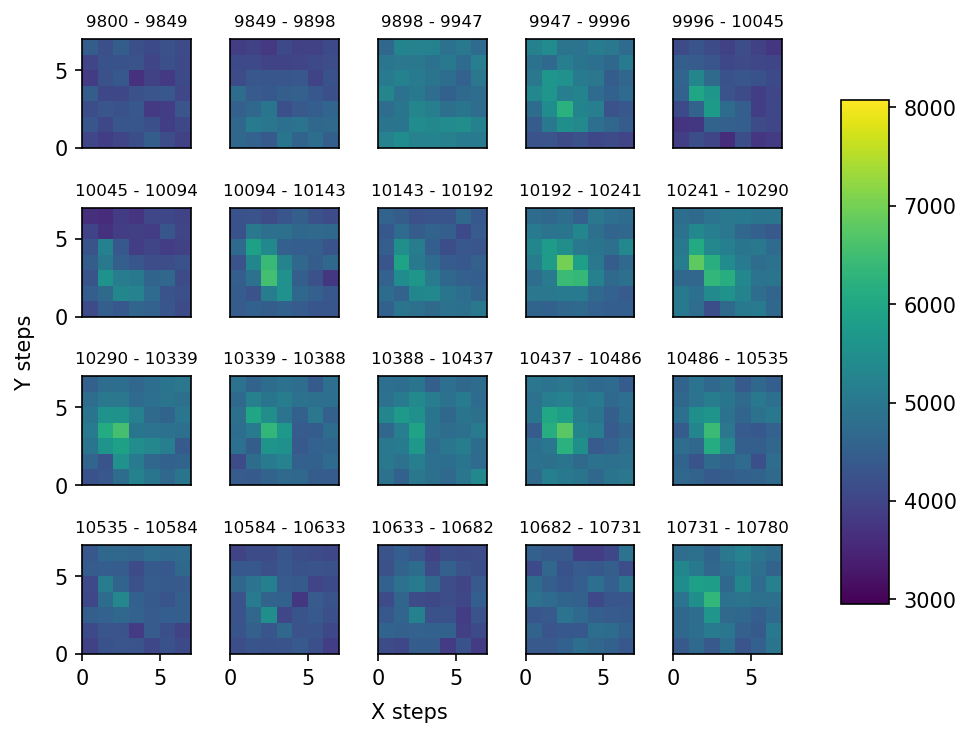

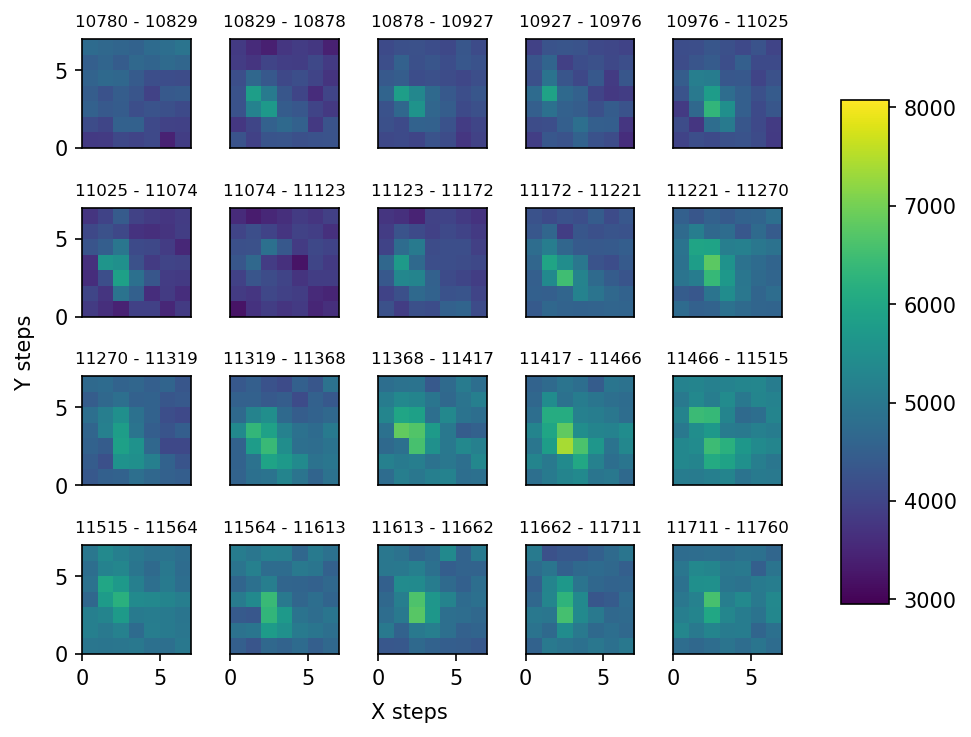

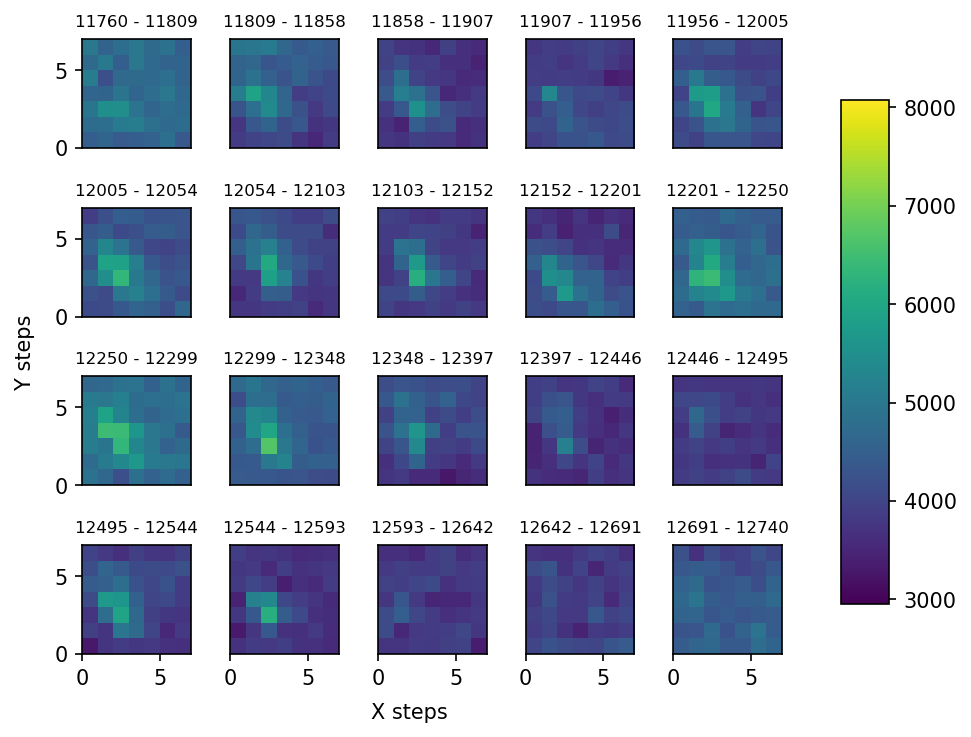

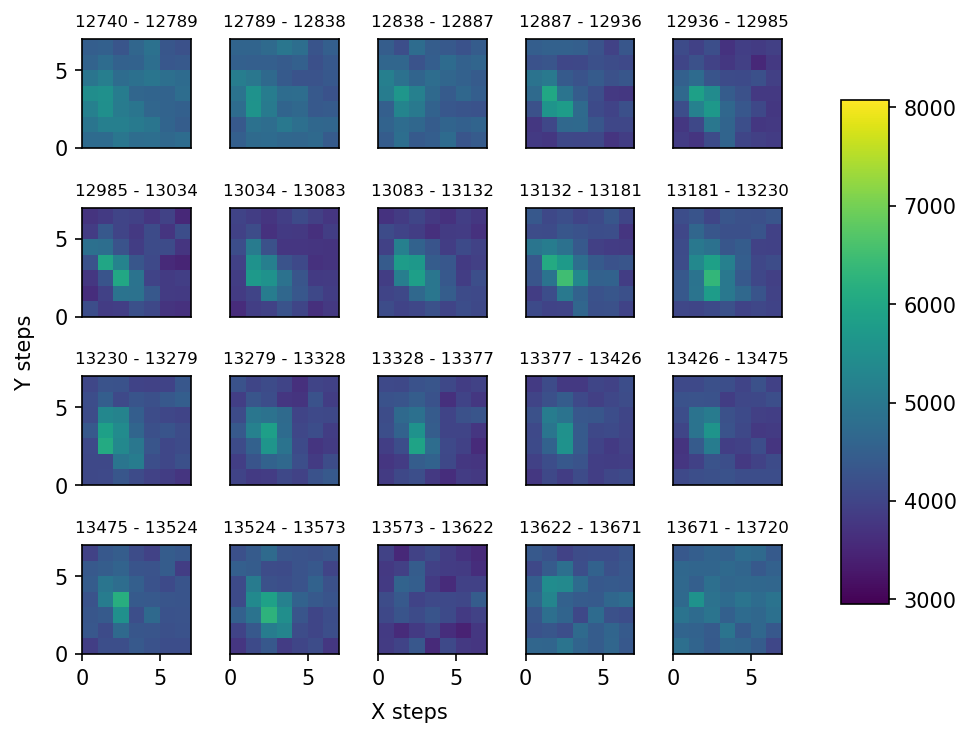

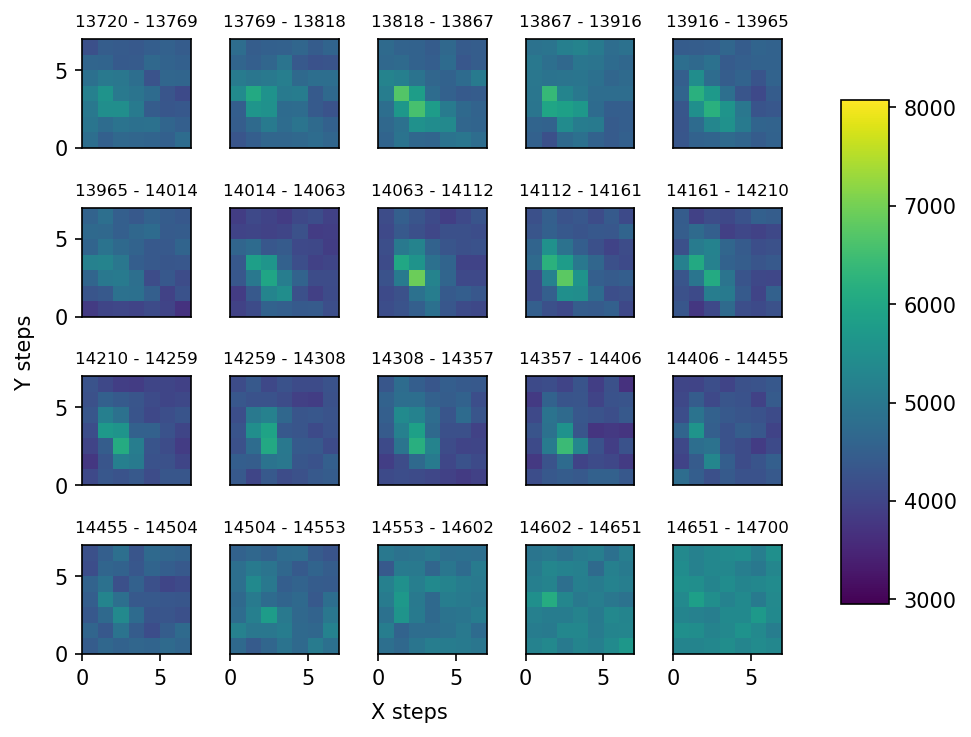

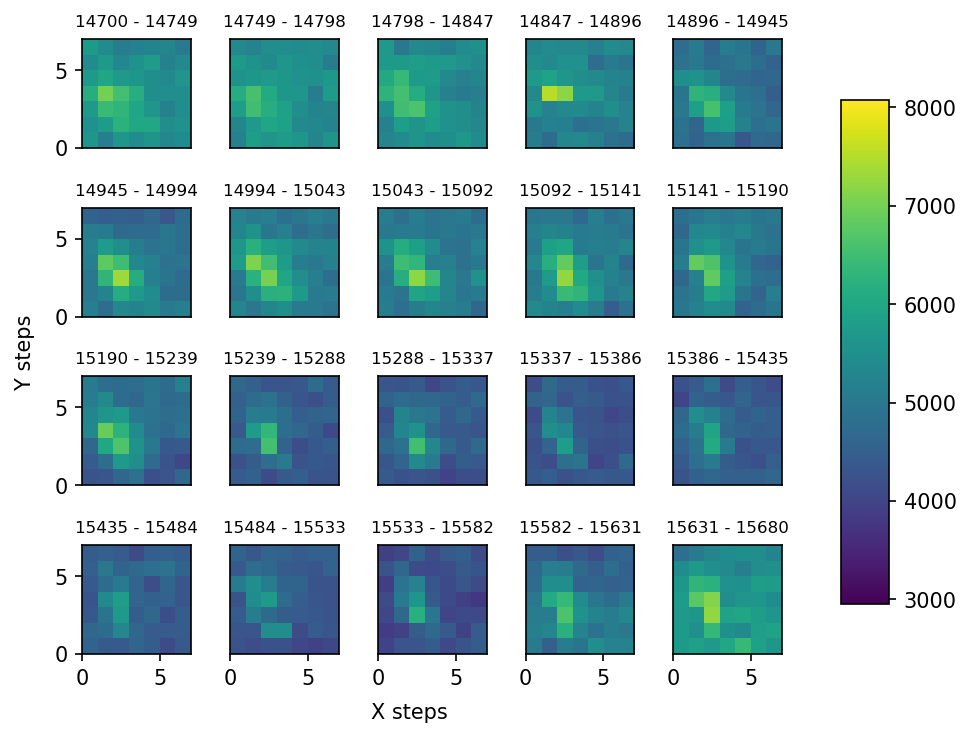

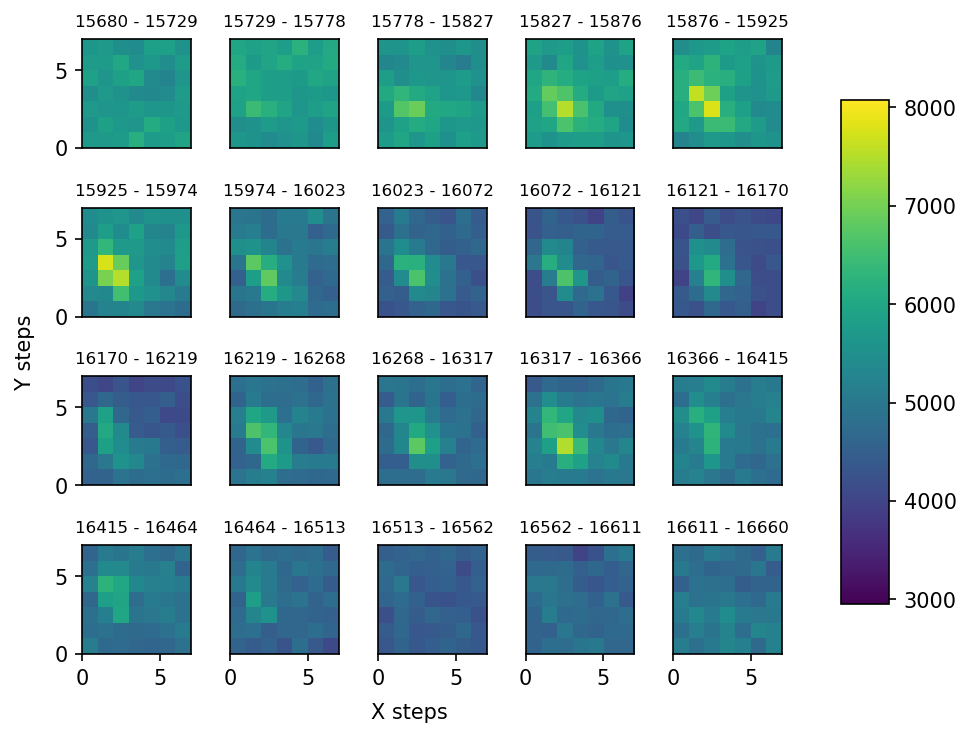

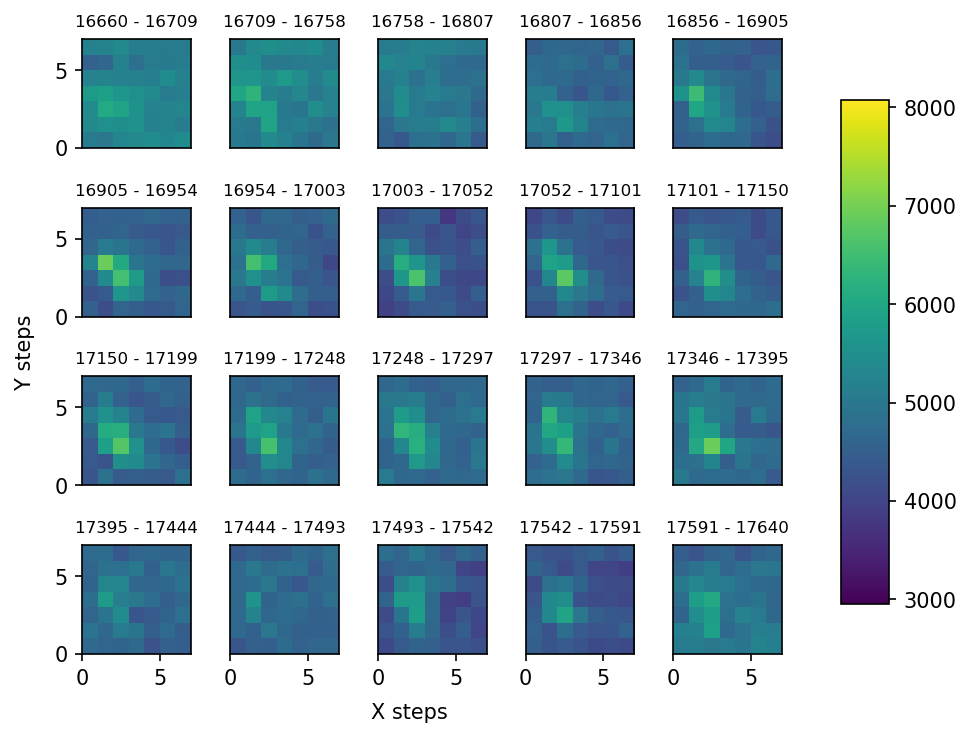

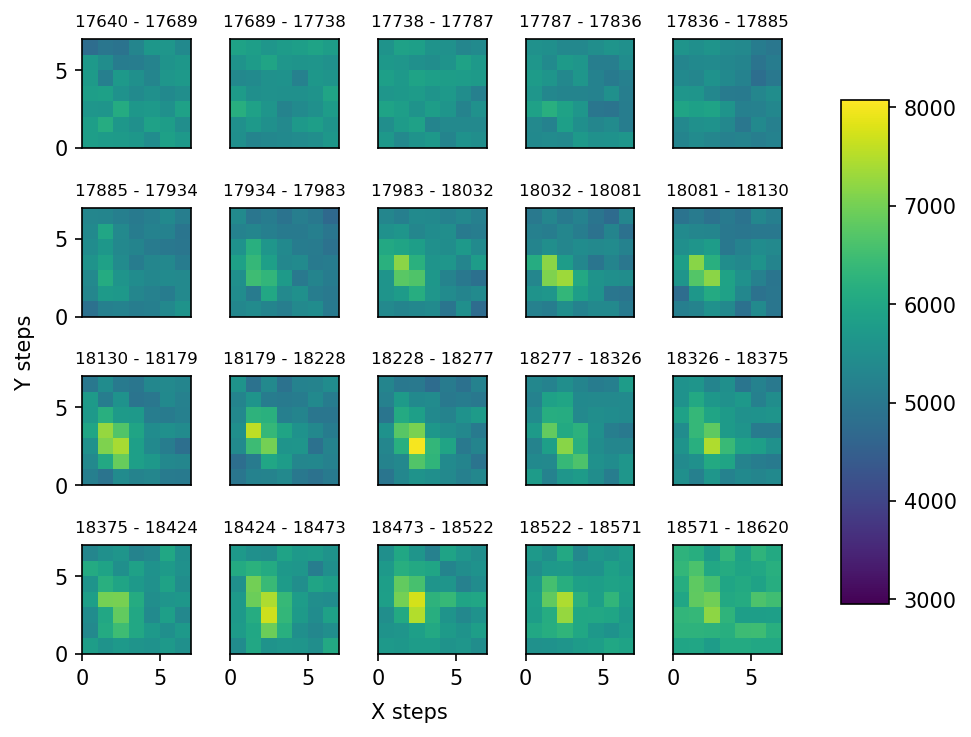

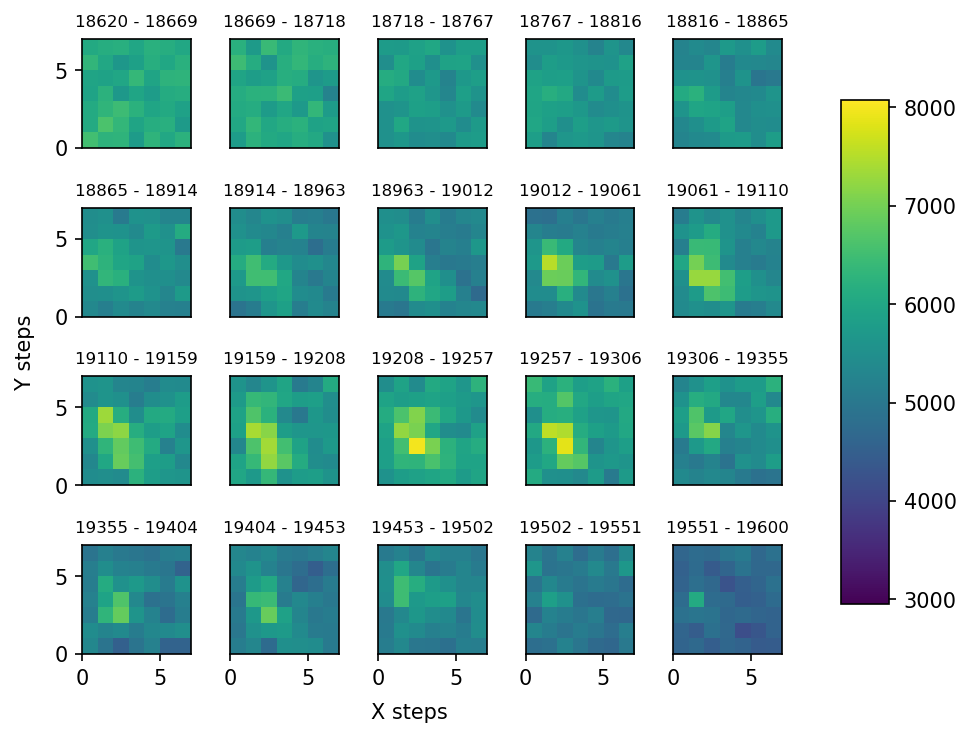

In [25]:
# this plotting procedure assumes that the order of the loops is ztop, zbottom, x, y

ymin = xmin = 0
xmax = ymax = xsteps # assumes ysteps = xsteps

maxcounts = max(counts)
mincounts = min(counts)

for k in range(ztop_steps):
    
    # one figure for each ztop step. each will contain one subplot for each zbottom step
    fig, axes = plt.subplots(nrows=nrows,ncols=ncols)
    
    for l,ax in enumerate(axes.flat):

#         ztop_step = k*ncols + col
#         zbottom_step = l*nrows + row

        # the step where we start counting from to get the counts at x and y steps
        # for the kth ztop step and lth zbottom step
        step0 = ysteps*xsteps*zbottom_steps*k + l*ysteps*xsteps

        imdata = counts[step0:step0+xsteps*ysteps].reshape((xsteps,ysteps))

        im = ax.imshow(imdata, extent=[ymin, ymax, xmin, xmax], vmin=mincounts, vmax=maxcounts)
        ax.set_aspect((ymax-ymin)/(xmax-xmin))
        ax.set_title(f"{step0} - {step0+xsteps*ysteps}",fontsize=8)

#         if col > 0:
#             ax.set_yticks([])
#         if row < 3:
#             ax.set_xticks([])

    # turn off redundant axes ticks
    if nrows > 1:
        [ax.set_xticks([]) for ax in axes[:-1,:].flat]
        [ax.set_yticks([]) for ax in axes[:,1:].flat]
    else:
        pass

    fig.tight_layout()
    fig.subplots_adjust(right=0.8)
    cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
    fig.colorbar(im, cax=cbar_ax)

    fig.text(0.4, 0, 'X steps', ha='center', va='center')
    fig.text(-0.0, 0.5, 'Y steps', ha='center', va='center', rotation='vertical')
    fig.dpi = 150
#         plt.savefig(datafile[:-4] + '_3D_' + str(k*(1+ncols) + l) + '.png', bbox_inches='tight')
#         plt.close()
    plt.show()

#     break

### August 2023

#### 2023.08.31
Bugs have been fixed in the feedback code and the signal is being averaged enough to keep the MOT beam fluctuations to 
less than 2% over 95% of the time. See wiki post from yesterday.

In [13]:
datafile = os.path.join(expdir,"20230830_141518_coil_scan.csv")
t_exp = 0.3 # the SPCM exposure time in seconds. 


has_header = True
with open(datafile, 'r', newline='') as f:
    reader = csv.reader(f)
    if has_header:
        header = reader.__next__()
    data = [row for row in reader]#[:5]
    f.close()

data = np.array(data,float).transpose()
# print(data)
rows,cols = data.shape

In [15]:
counts = data[0]/t_exp # data is total counts in the exposure time. data/t_exp is the rate.
pd_data = data[-1] # the cooling laser power monitor
coil_data = data[1:-1]#[:12800] # just as a check. should make two figures

zbottom_data, ztop_data, xdata, ydata = coil_data

zbottom_steps = len(list(set(zbottom_data)))
ztop_steps = len(list(set(zbottom_data)))
xsteps = len(list(set(xdata)))
ysteps = len(list(set(ydata)))

In [16]:
### nrows and ncols are the number of subplots in each image
nrows = 4
ncols = 5
assert nrows * ncols == zbottom_steps, f"the number of subplots should be zbottom_steps={zbottom_steps}"

In [17]:
k = l = 0
ysteps*xsteps*zbottom_steps*k + l*ysteps*xsteps
xsteps*ysteps

121

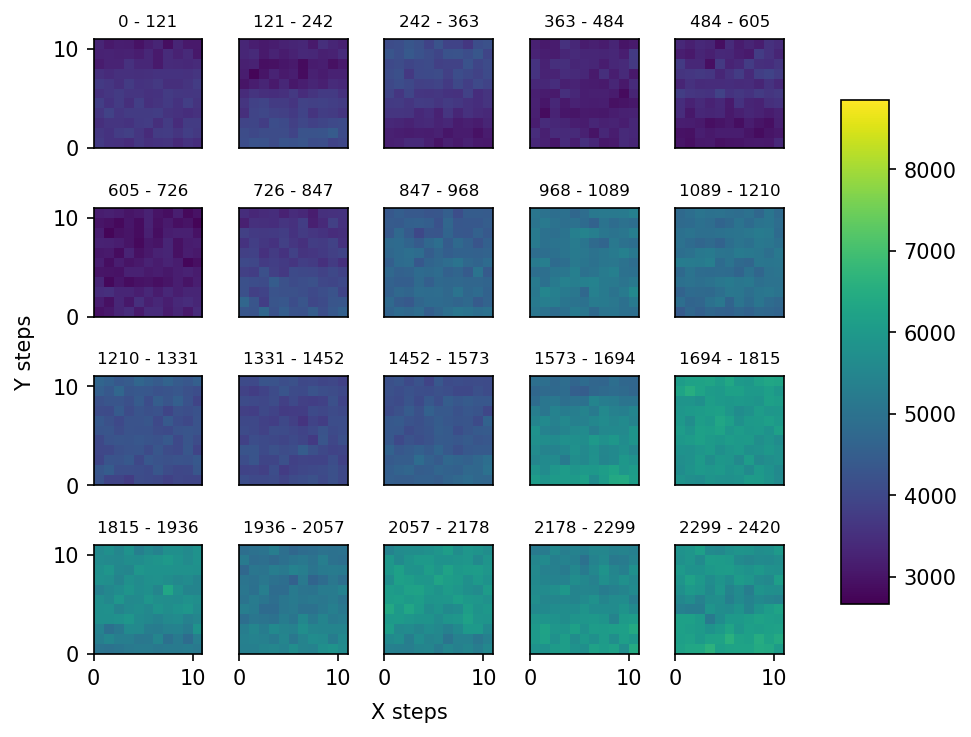

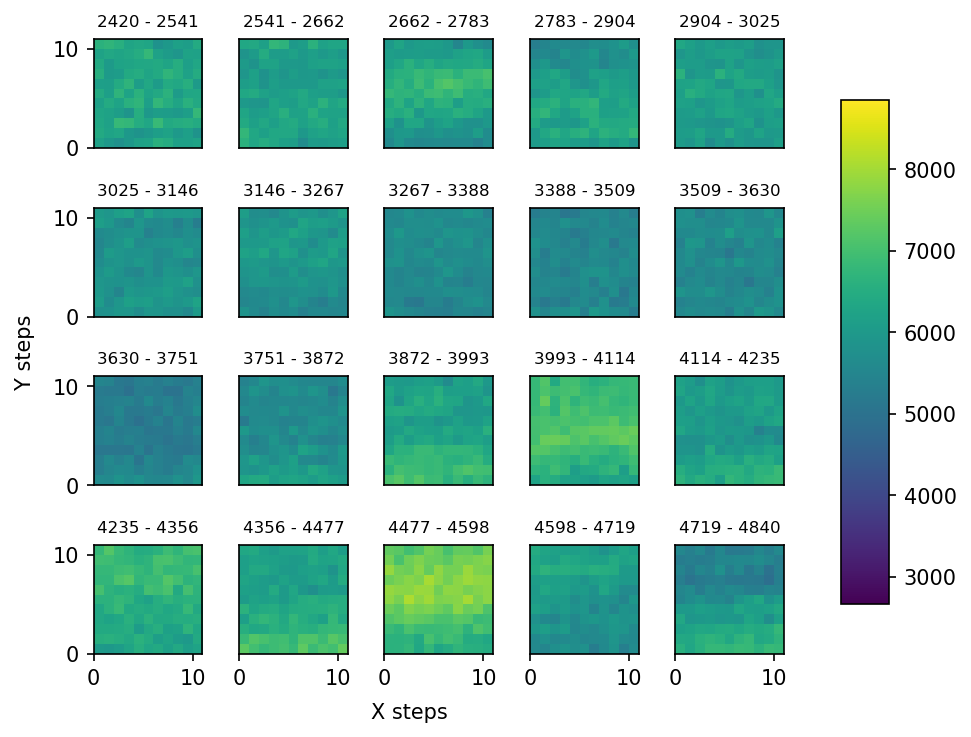

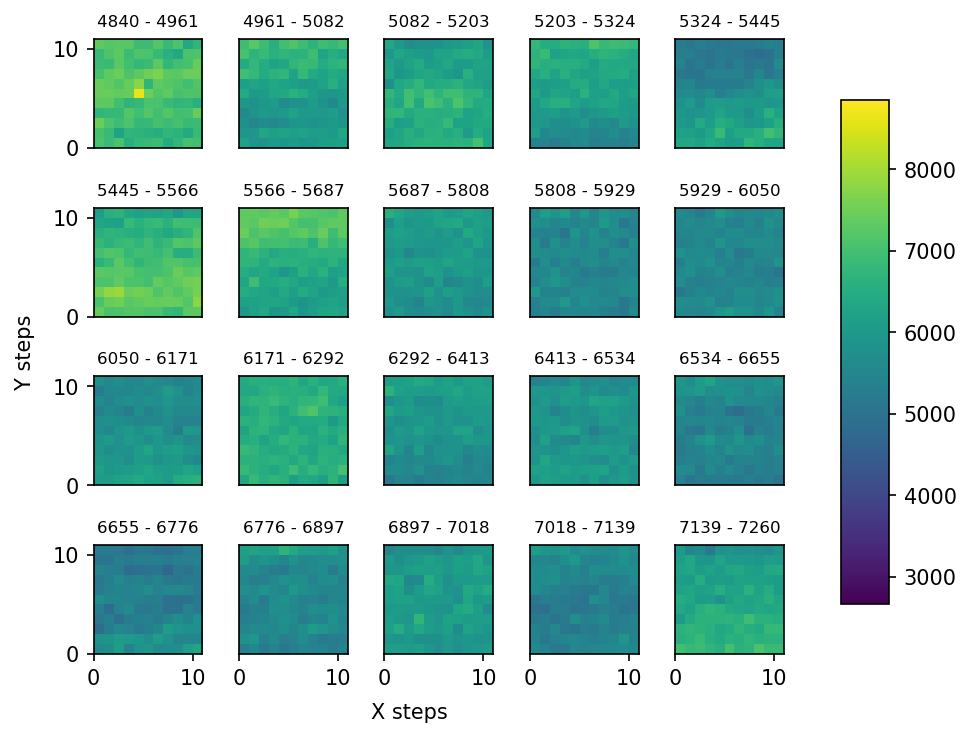

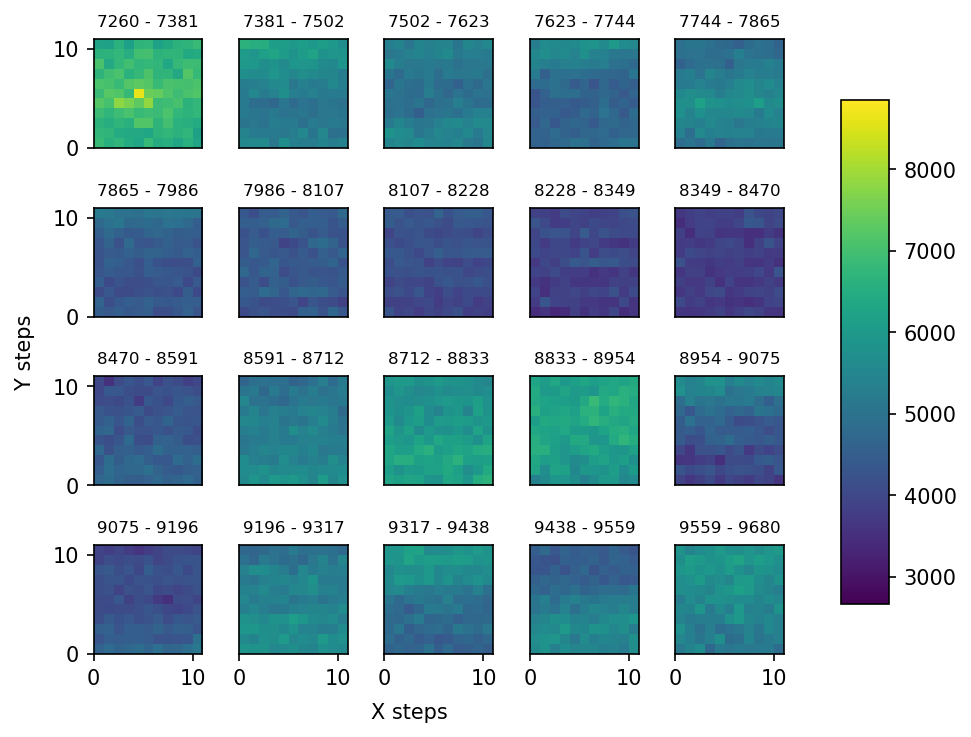

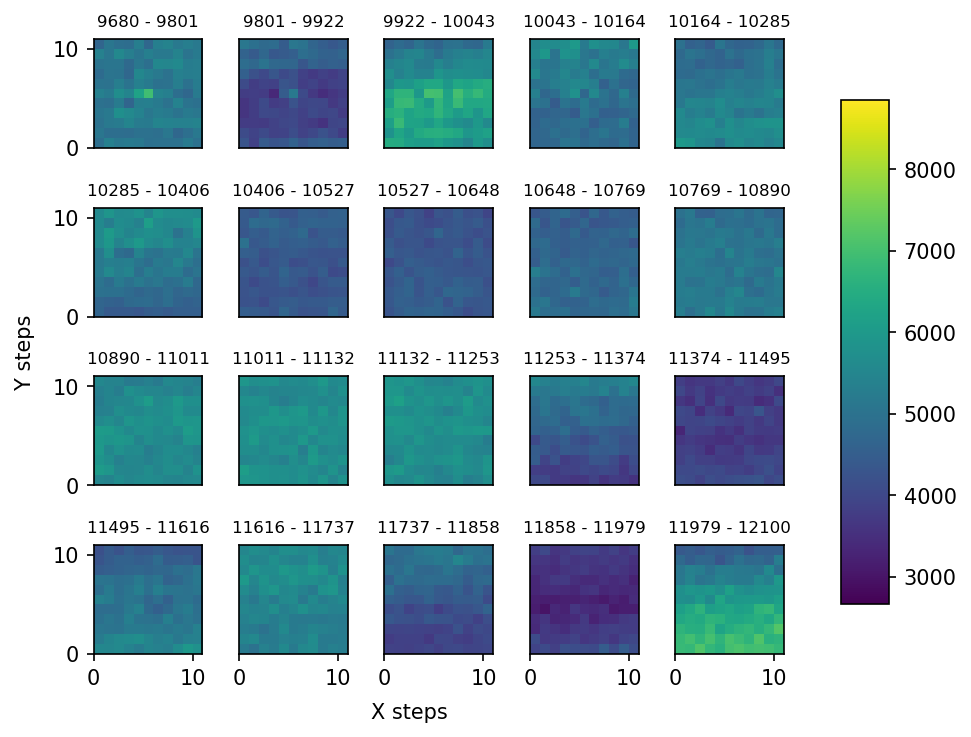

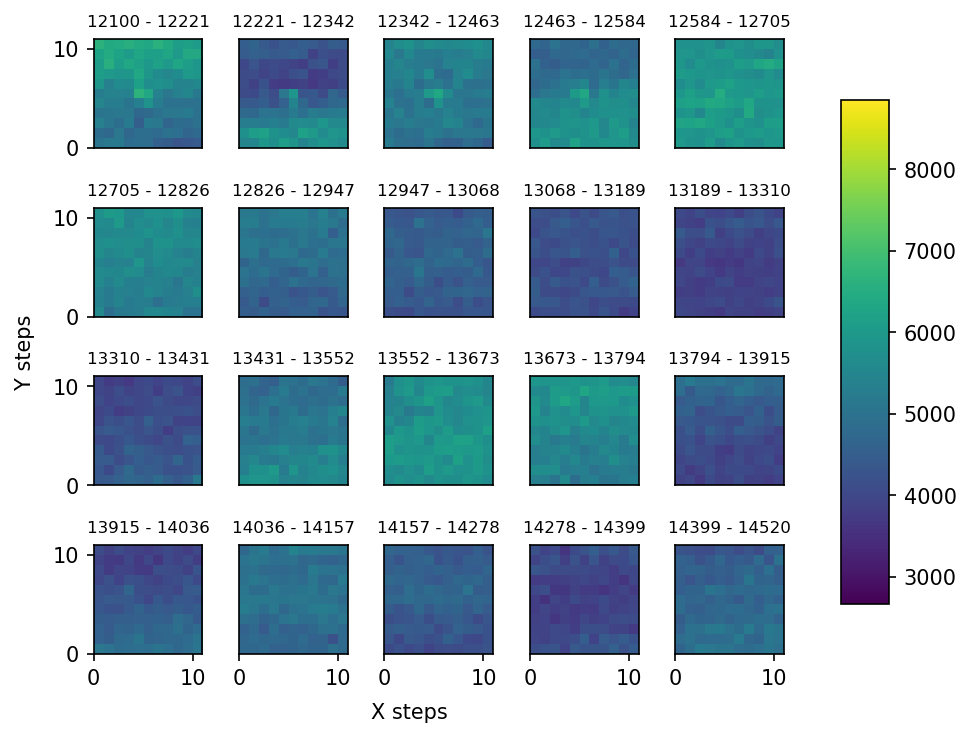

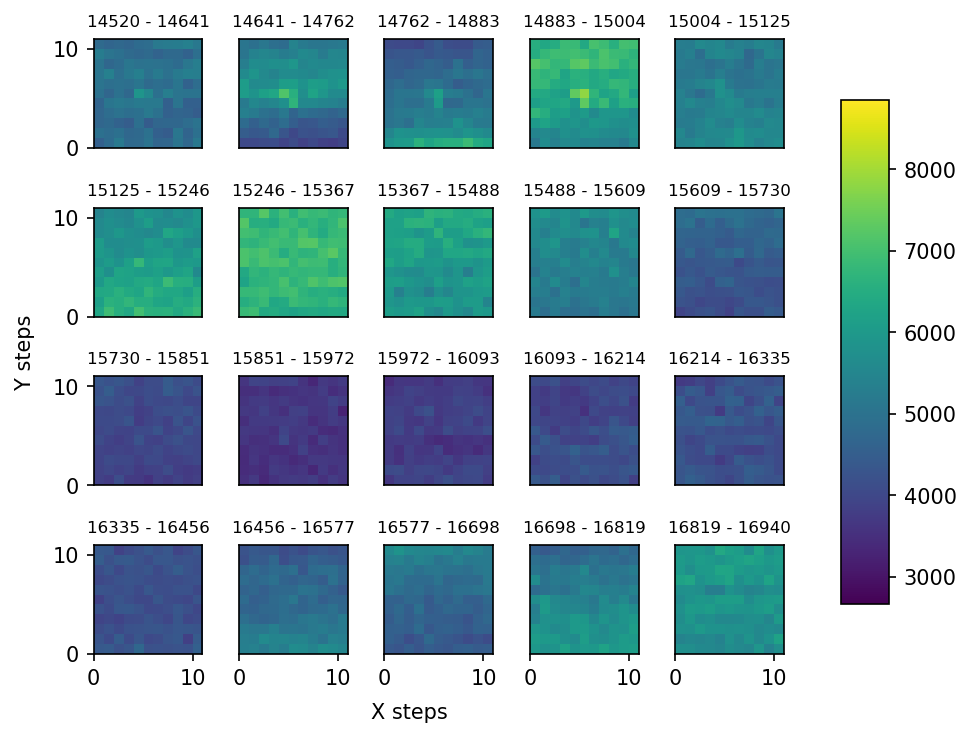

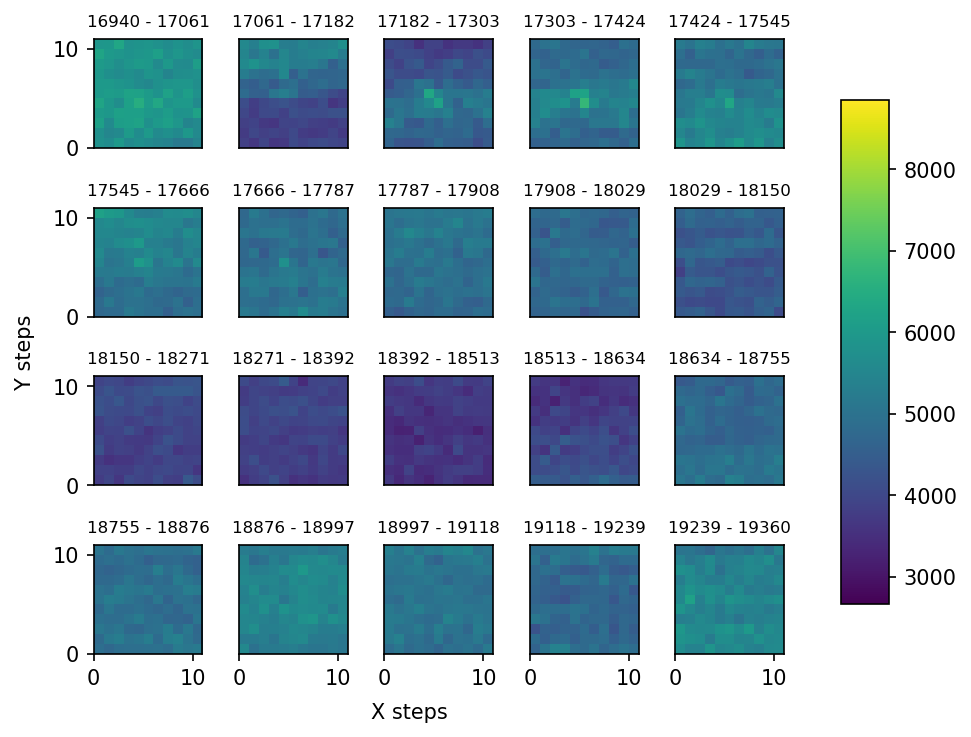

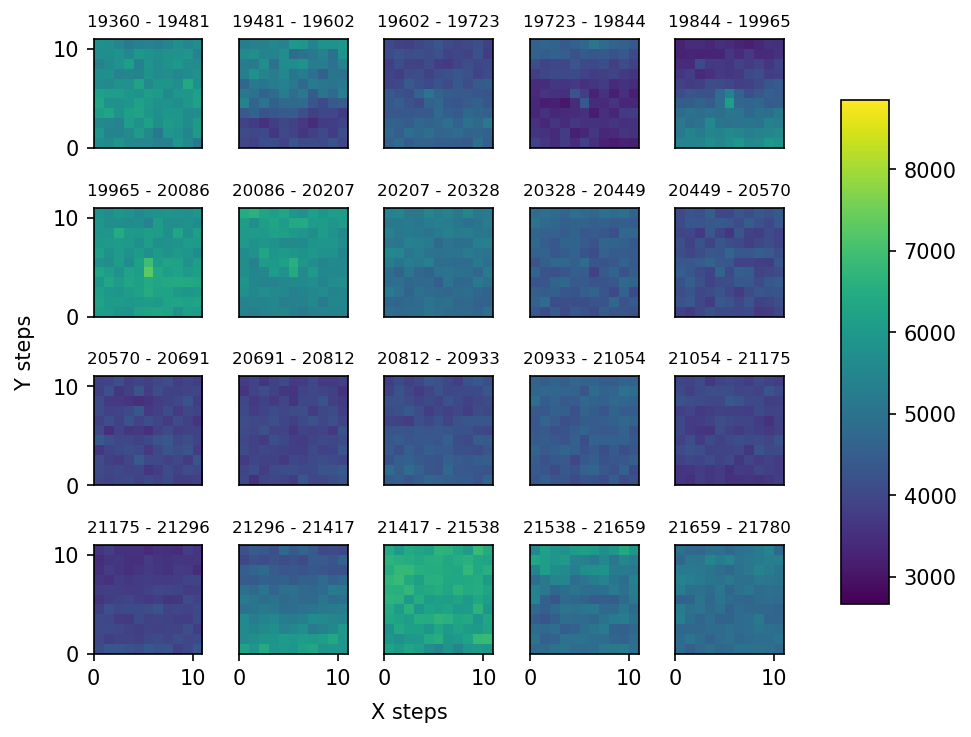

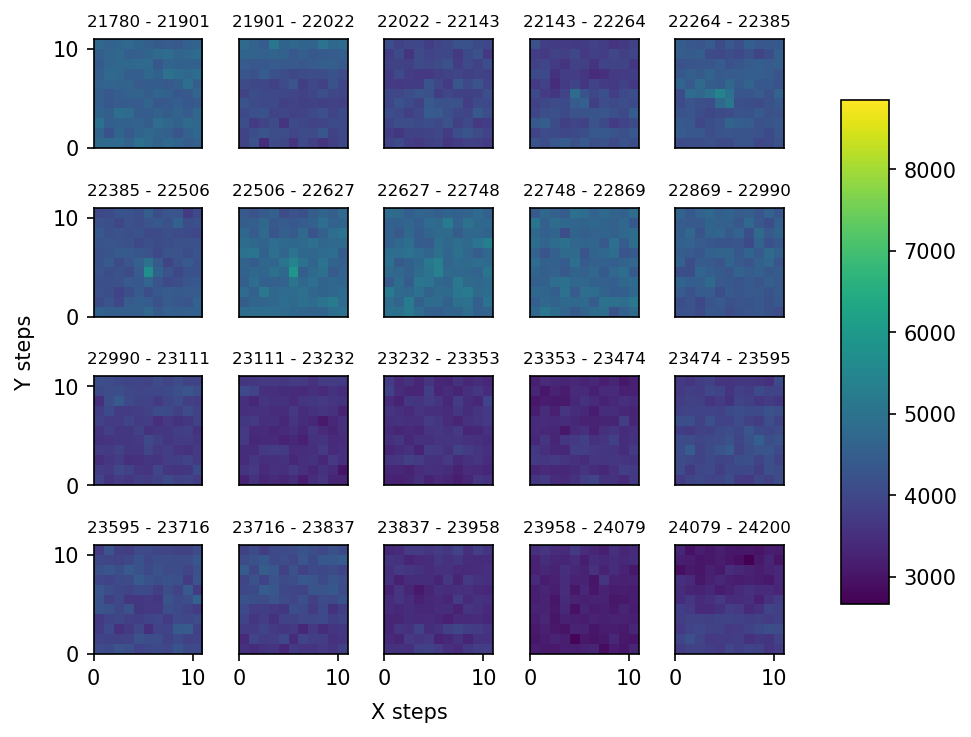

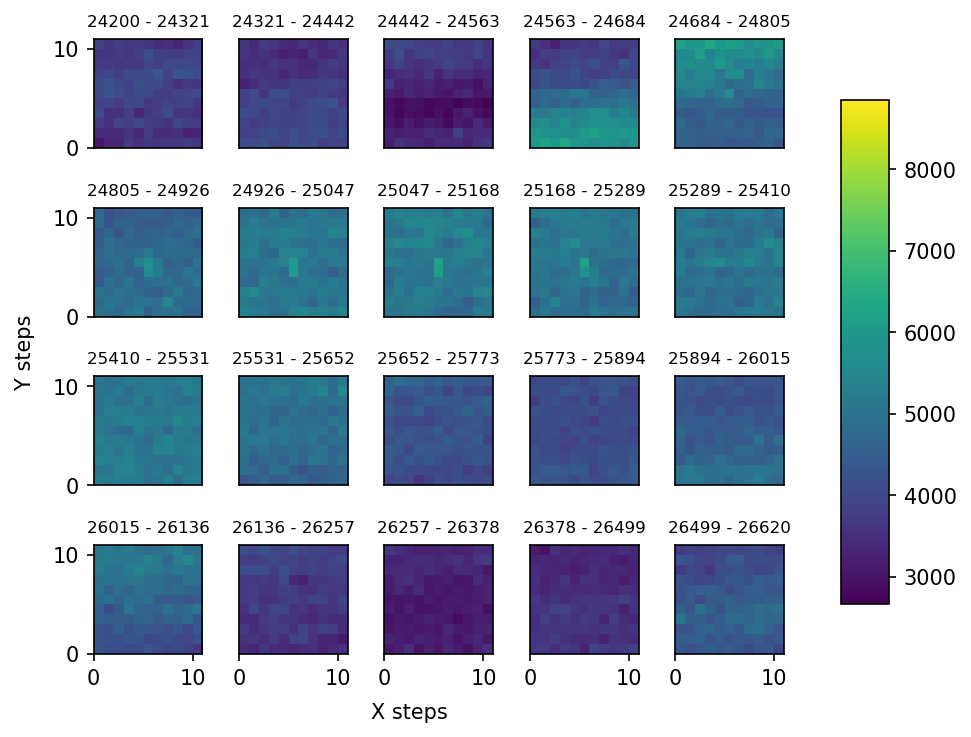

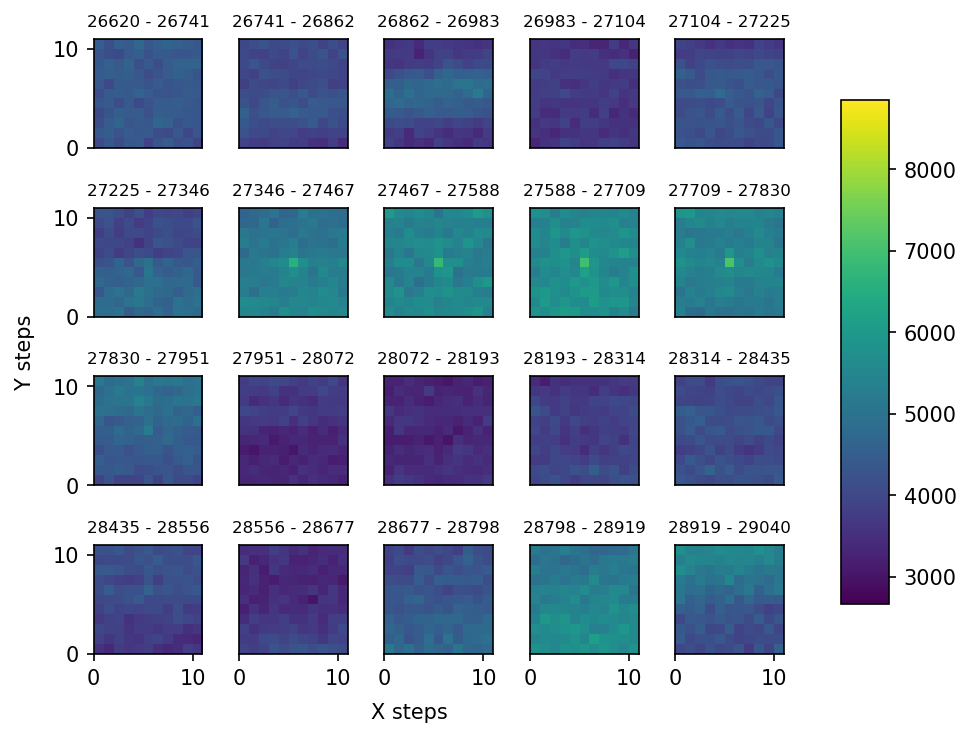

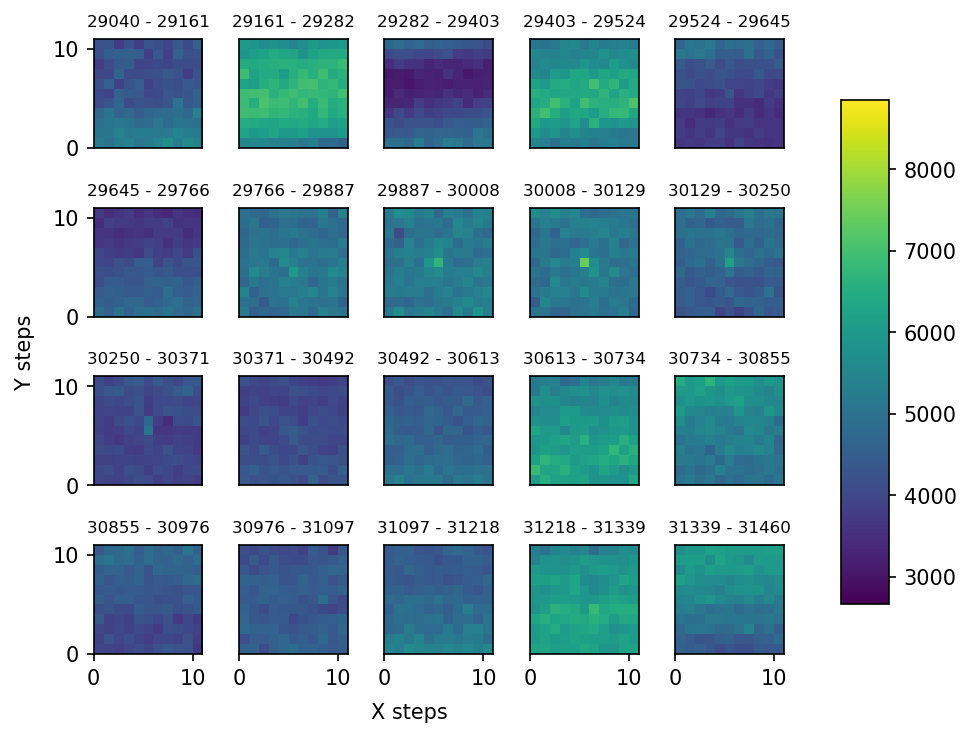

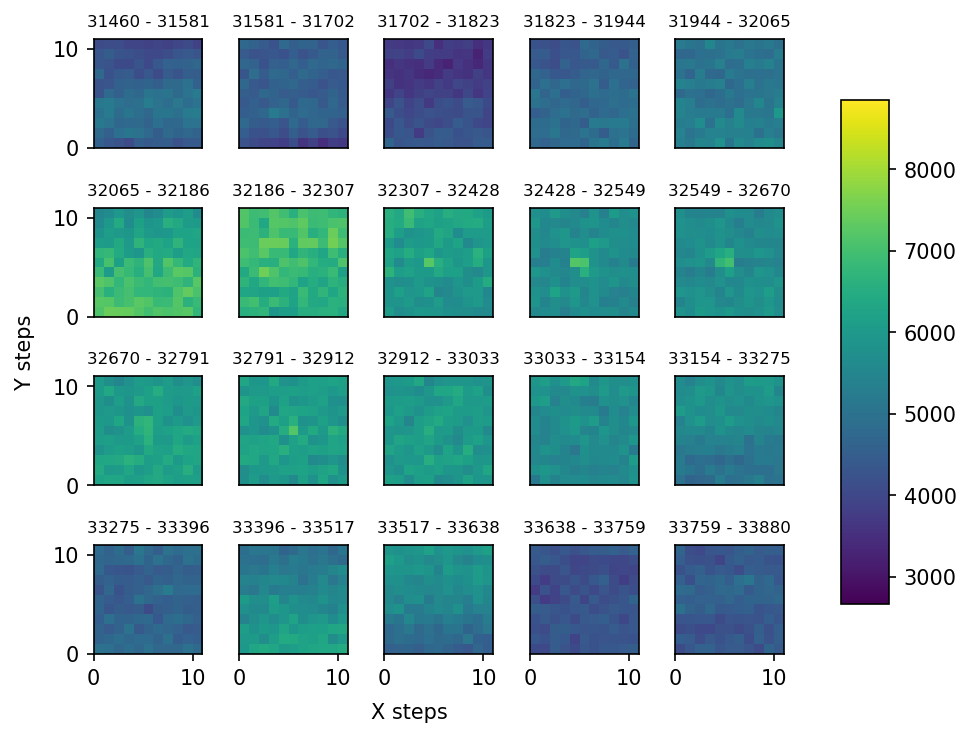

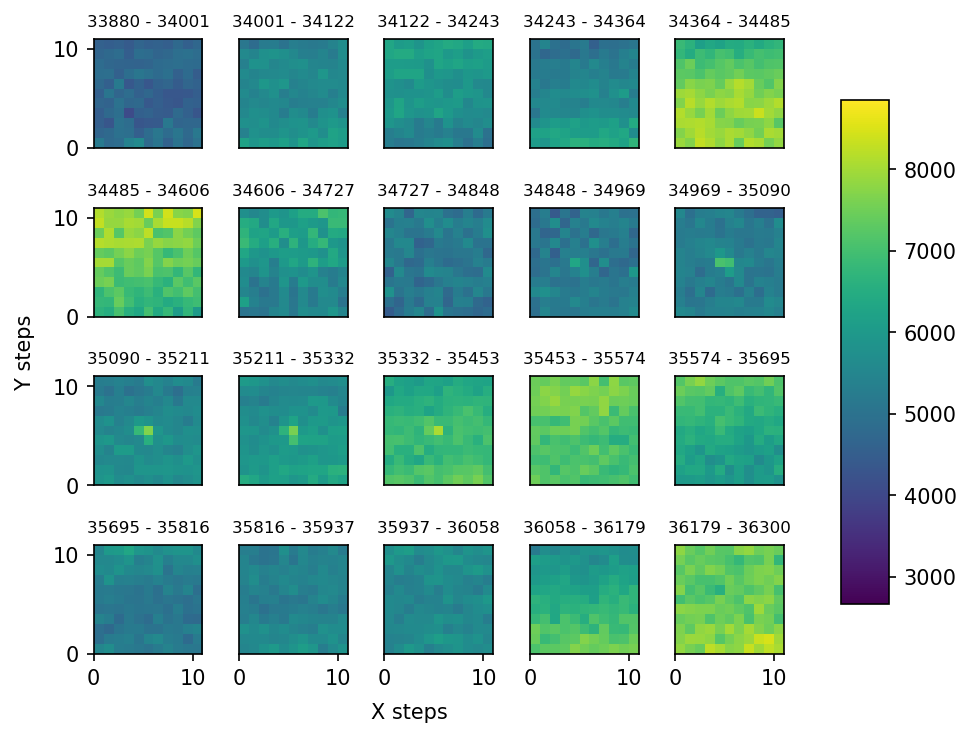

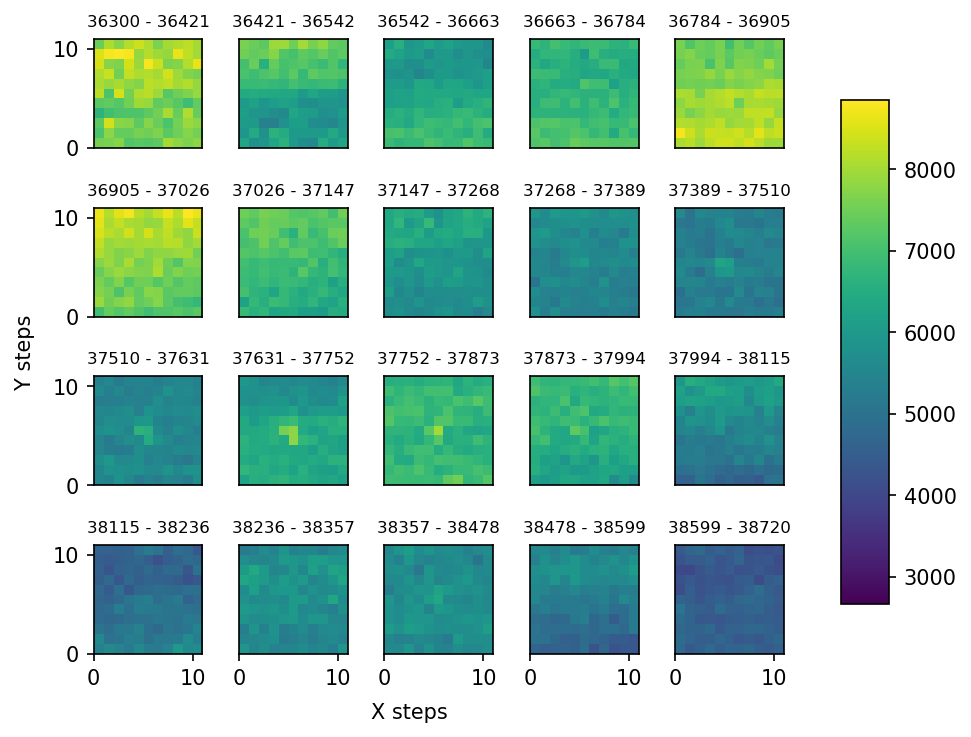

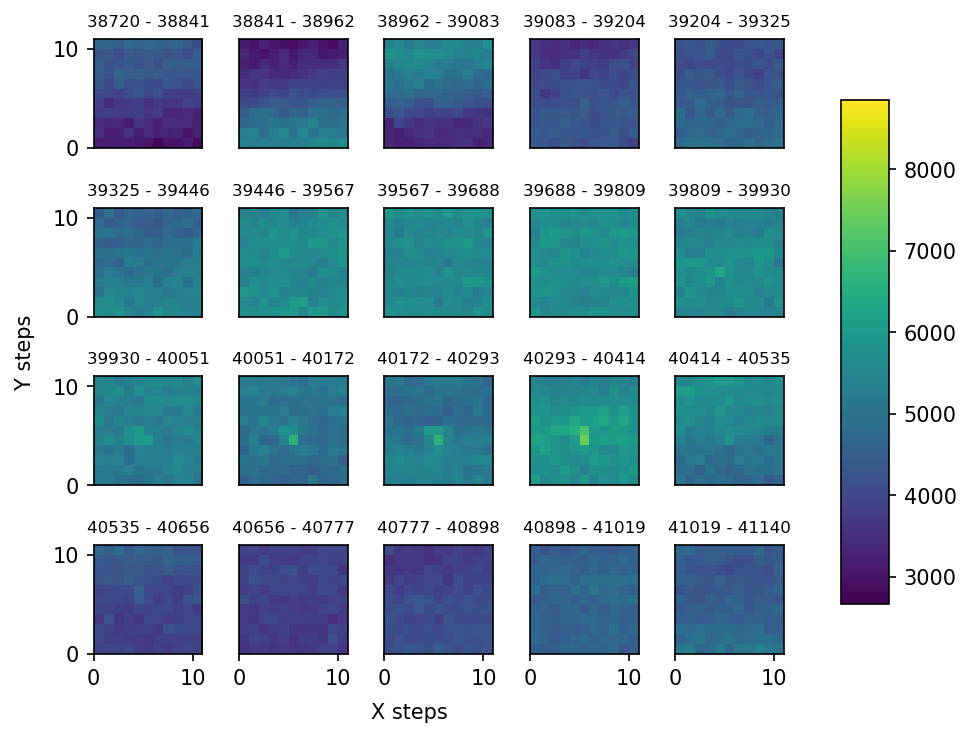

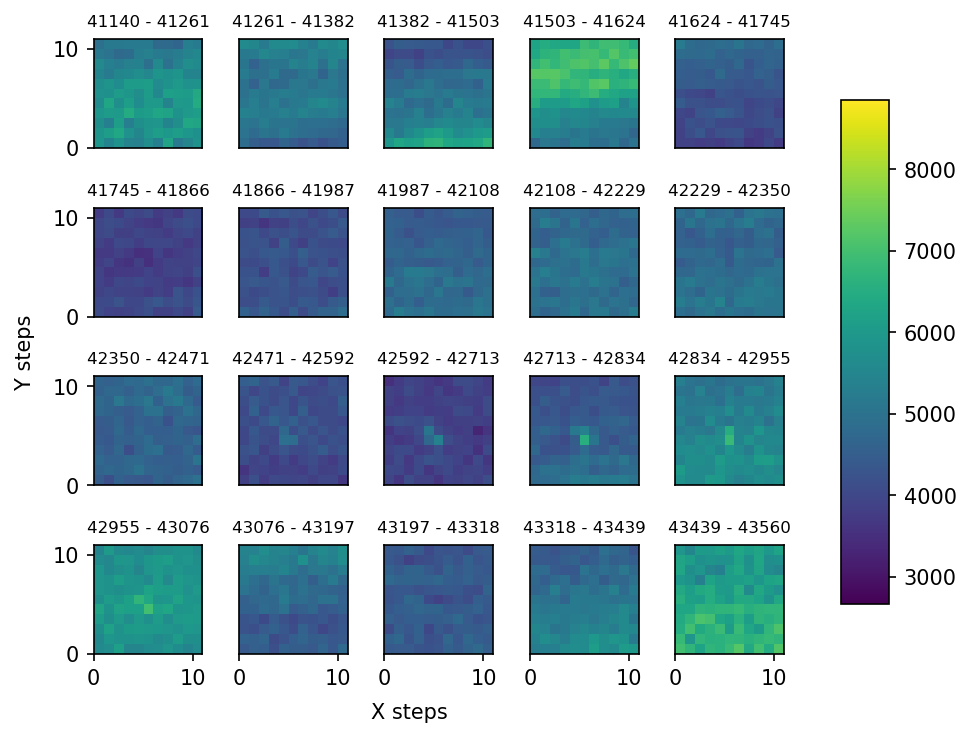

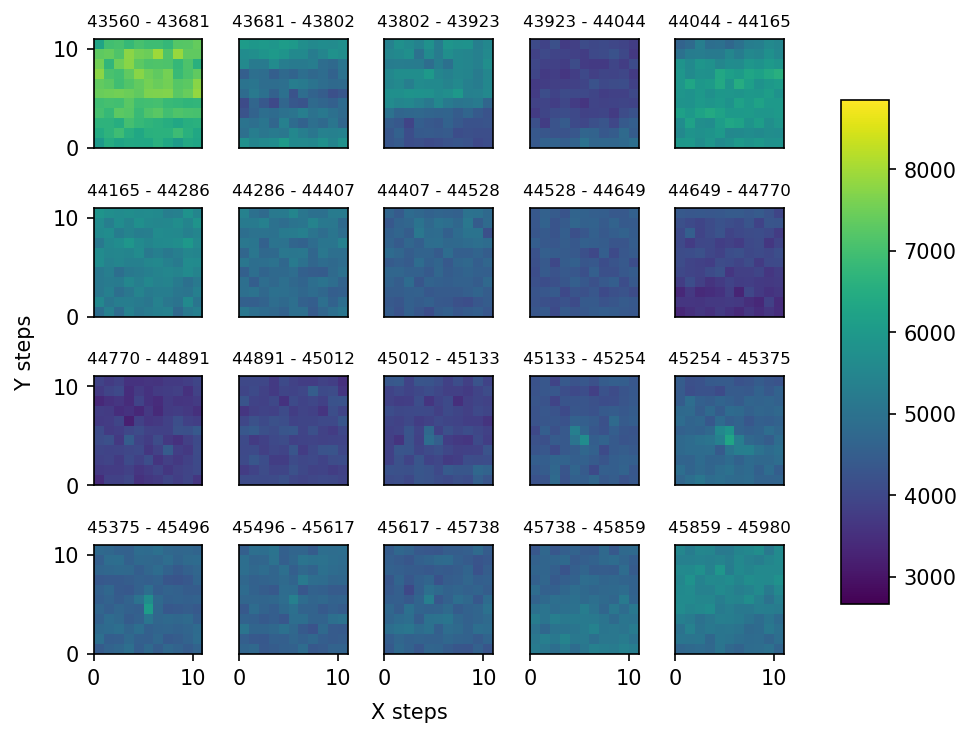

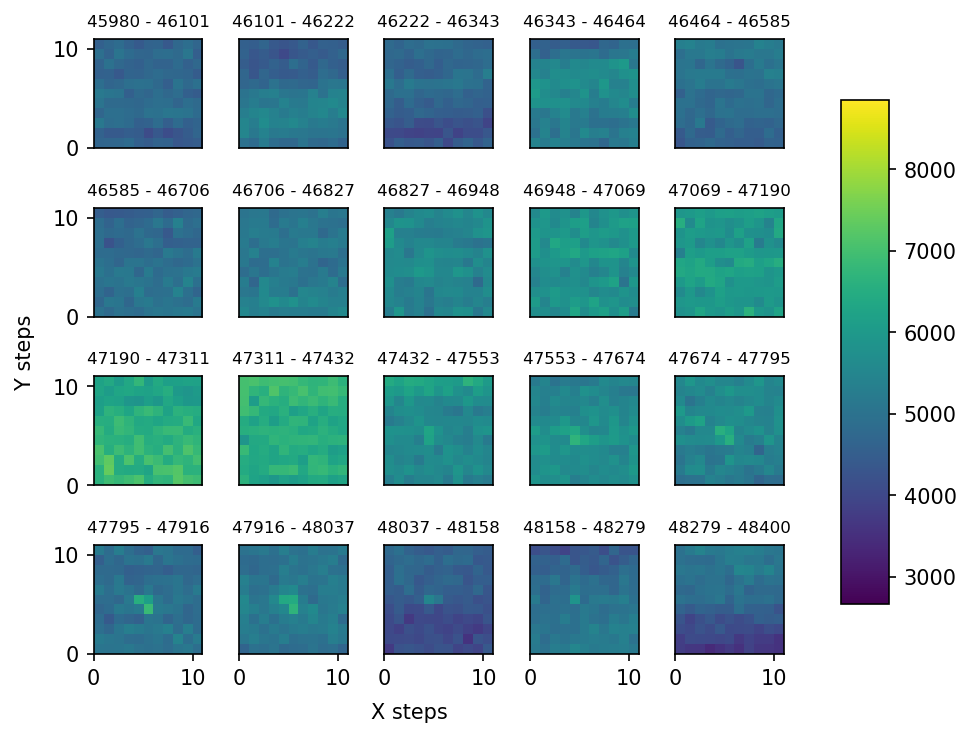

In [18]:
# this plotting procedure assumes that the order of the loops is ztop, zbottom, x, y

ymin = xmin = 0
xmax = ymax = xsteps # assumes ysteps = xsteps

maxcounts = max(counts)
mincounts = min(counts)

for k in range(ztop_steps):
    
    # one figure for each ztop step. each will contain one subplot for each zbottom step
    fig, axes = plt.subplots(nrows=nrows,ncols=ncols)
    
    for l,ax in enumerate(axes.flat):

#         ztop_step = k*ncols + col
#         zbottom_step = l*nrows + row

        # the step where we start counting from to get the counts at x and y steps
        # for the kth ztop step and lth zbottom step
        step0 = ysteps*xsteps*zbottom_steps*k + l*ysteps*xsteps

        imdata = counts[step0:step0+xsteps*ysteps].reshape((xsteps,ysteps))

        im = ax.imshow(imdata, extent=[ymin, ymax, xmin, xmax], vmin=mincounts, vmax=maxcounts)
        ax.set_aspect((ymax-ymin)/(xmax-xmin))
        ax.set_title(f"{step0} - {step0+xsteps*ysteps}",fontsize=8)

#         if col > 0:
#             ax.set_yticks([])
#         if row < 3:
#             ax.set_xticks([])

    # turn off redundant axes ticks
    if nrows > 1:
        [ax.set_xticks([]) for ax in axes[:-1,:].flat]
        [ax.set_yticks([]) for ax in axes[:,1:].flat]
    else:
        pass

    fig.tight_layout()
    fig.subplots_adjust(right=0.8)
    cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
    fig.colorbar(im, cax=cbar_ax)

    fig.text(0.4, 0, 'X steps', ha='center', va='center')
    fig.text(-0.0, 0.5, 'Y steps', ha='center', va='center', rotation='vertical')
    fig.dpi = 150
#         plt.savefig(datafile[:-4] + '_3D_' + str(k*(1+ncols) + l) + '.png', bbox_inches='tight')
#         plt.close()
    plt.show()

#     break

maxidx=30068, maxct=7453.333333333334, Vpd=-0.01251220703125
coil VZbottom, VZtop, VX, VY = (6.842105263157895, 7.2631578947368425, 0.0, 0.0)


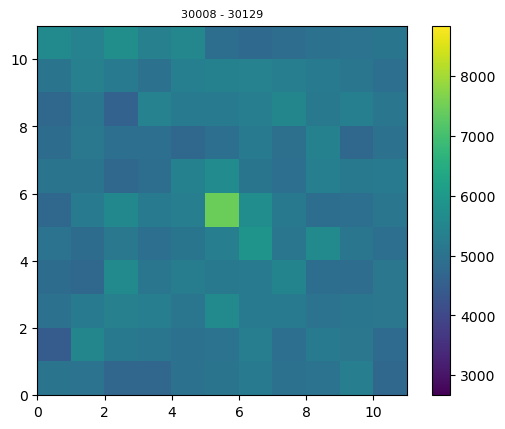

In [20]:
# Starting with these settings, I was able to manually tune coils to get ~ 9000 Hz (the fluorescence
# background was around 5000 though)
# 6.05 V, 6.55 V, 0.07 V, -0.17 V

# local max for a given step range
step0 = 30008 #xsteps*ysteps*(200//(xsteps*ysteps)) #33600 # start here, as motivating by looking at the images we saved

fig,ax = plt.subplots()

imdata = counts[step0:step0+xsteps*ysteps].reshape((xsteps,ysteps))
maxct,maxidx = get_max_idx(counts[step0:step0+xsteps*ysteps])
maxidx += step0
print(f"maxidx={maxidx}, maxct={maxct}, Vpd={pd_data[maxidx]}")
print(f"coil VZbottom, VZtop, VX, VY = {zbottom_data[maxidx], ztop_data[maxidx], xdata[maxidx], ydata[maxidx]}")

im = ax.imshow(imdata, extent=[ymin, ymax, xmin, xmax], vmin=mincounts, vmax=maxcounts)
ax.set_aspect((ymax-ymin)/(xmax-xmin))
ax.set_title(f"{step0} - {step0+xsteps*ysteps}",fontsize=8)
fig.colorbar(im)

maxidx=47866, maxct=2058.0, Vpd=-0.01190185546875
coil VZbottom, VZtop, VX, VY = (7.578947368421053, 8.0, 0.15999999999999992, 0.0)


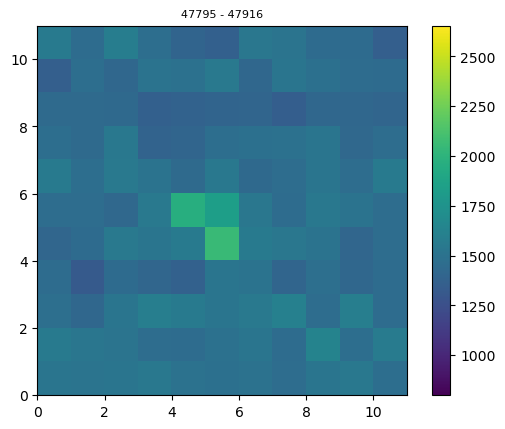

In [11]:
# Starting with these settings, I was able to manually tune coils to get ~ 9000 Hz (the fluorescence
# background was around 5000 though)
# 6.05 V, 6.55 V, 0.07 V, -0.17 V

# local max for a given step range
step0 = 47795 #xsteps*ysteps*(200//(xsteps*ysteps)) #33600 # start here, as motivating by looking at the images we saved

fig,ax = plt.subplots()

imdata = counts[step0:step0+xsteps*ysteps].reshape((xsteps,ysteps))
maxct,maxidx = get_max_idx(counts[step0:step0+xsteps*ysteps])
maxidx += step0
print(f"maxidx={maxidx}, maxct={maxct}, Vpd={pd_data[maxidx]}")
print(f"coil VZbottom, VZtop, VX, VY = {zbottom_data[maxidx], ztop_data[maxidx], xdata[maxidx], ydata[maxidx]}")

im = ax.imshow(imdata, extent=[ymin, ymax, xmin, xmax], vmin=mincounts, vmax=maxcounts)
ax.set_aspect((ymax-ymin)/(xmax-xmin))
ax.set_title(f"{step0} - {step0+xsteps*ysteps}",fontsize=8)
fig.colorbar(im)

maxidx=35150, maxct=2301.0, Vpd=-0.01312255859375
coil VZbottom, VZtop, VX, VY = (7.052631578947368, 7.473684210526316, 0.0, 0.0)


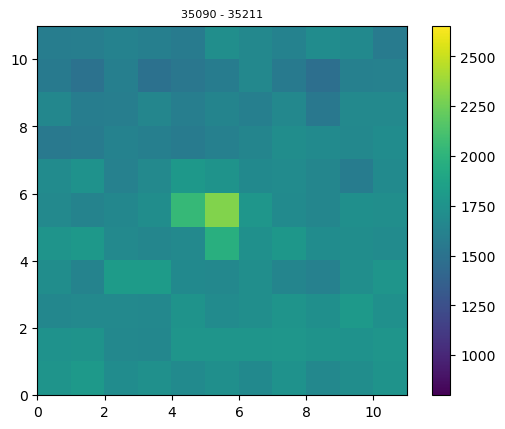

In [12]:
# Starting with these settings, I was able to manually tune coils to get ~ 10000 Hz (the fluorescence
# background was around 5000)
# 7.38 V, 7.91 V, 0.12 V, -0.19 V

# local max for a given step range
step0 = 35090 #xsteps*ysteps*(200//(xsteps*ysteps)) #33600 # start here, as motivating by looking at the images we saved

fig,ax = plt.subplots()

imdata = counts[step0:step0+xsteps*ysteps].reshape((xsteps,ysteps))
maxct,maxidx = get_max_idx(counts[step0:step0+xsteps*ysteps])
maxidx += step0
print(f"maxidx={maxidx}, maxct={maxct}, Vpd={pd_data[maxidx]}")
print(f"coil VZbottom, VZtop, VX, VY = {zbottom_data[maxidx], ztop_data[maxidx], xdata[maxidx], ydata[maxidx]}")

im = ax.imshow(imdata, extent=[ymin, ymax, xmin, xmax], vmin=mincounts, vmax=maxcounts)
ax.set_aspect((ymax-ymin)/(xmax-xmin))
ax.set_title(f"{step0} - {step0+xsteps*ysteps}",fontsize=8)
fig.colorbar(im)

maxidx=7319, maxct=2589.0, Vpd=-0.01373291015625
coil VZbottom, VZtop, VX, VY = (6.0, 6.315789473684211, 0.0, -0.16000000000000003)


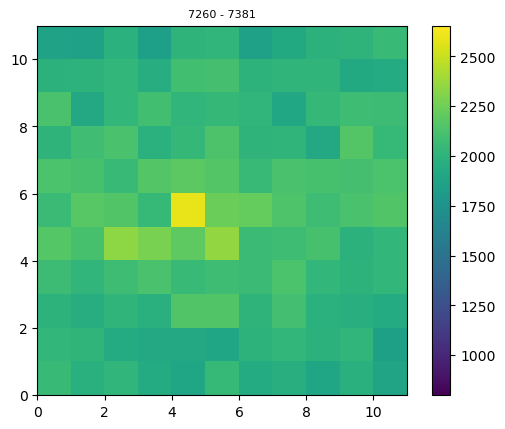

In [10]:
# local max for a given step range
step0 = 7260 #xsteps*ysteps*(200//(xsteps*ysteps)) #33600 # start here, as motivating by looking at the images we saved

fig,ax = plt.subplots()

imdata = counts[step0:step0+xsteps*ysteps].reshape((xsteps,ysteps))
maxct,maxidx = get_max_idx(counts[step0:step0+xsteps*ysteps])
maxidx += step0
print(f"maxidx={maxidx}, maxct={maxct}, Vpd={pd_data[maxidx]}")
print(f"coil VZbottom, VZtop, VX, VY = {zbottom_data[maxidx], ztop_data[maxidx], xdata[maxidx], ydata[maxidx]}")

im = ax.imshow(imdata, extent=[ymin, ymax, xmin, xmax], vmin=mincounts, vmax=maxcounts)
ax.set_aspect((ymax-ymin)/(xmax-xmin))
ax.set_title(f"{step0} - {step0+xsteps*ysteps}",fontsize=8)
fig.colorbar(im)

IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

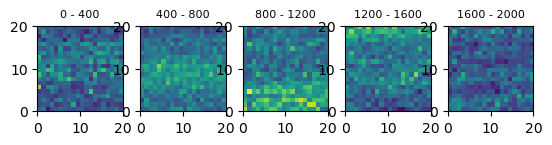

In [12]:
# this plotting procedure assumes that the order of the loops is ztop, zbottom, x, yb

ymin = xmin = 0
xmax = ymax = xsteps # assumes ysteps = xsteps

maxcounts = max(counts)
mincounts = min(counts)

for k in range(ztop_steps):
    
    # one figure for each ztop step. each will contain one subplot for each zbottom step
    fig, axes = plt.subplots(nrows=nrows,ncols=ncols)
    
    for l,ax in enumerate(axes.flat):

#         ztop_step = k*ncols + col
#         zbottom_step = l*nrows + row

        # the step where we start counting from to get the counts at x and y steps
        # for the kth ztop step and lth zbottom step
        step0 = ysteps*xsteps*zbottom_steps*k + l*ysteps*xsteps

        imdata = counts[step0:step0+xsteps*ysteps].reshape((xsteps,ysteps))

        im = ax.imshow(imdata, extent=[ymin, ymax, xmin, xmax], vmin=mincounts, vmax=maxcounts)
        ax.set_aspect((ymax-ymin)/(xmax-xmin))
        ax.set_title(f"{step0} - {step0+xsteps*ysteps}",fontsize=8)

#         if col > 0:
#             ax.set_yticks([])
#         if row < 3:
#             ax.set_xticks([])

    # turn off redundant axes ticks
    [ax.set_xticks([]) for ax in axes[:-1,:].flat]
    [ax.set_yticks([]) for ax in axes[:,1:].flat]

    fig.tight_layout()
    fig.subplots_adjust(right=0.8)
    cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
    fig.colorbar(im, cax=cbar_ax)

    fig.text(0.4, 0, 'X steps', ha='center', va='center')
    fig.text(-0.0, 0.5, 'Y steps', ha='center', va='center', rotation='vertical')
    fig.dpi = 150
#         plt.savefig(datafile[:-4] + '_3D_' + str(k*(1+ncols) + l) + '.png', bbox_inches='tight')
#         plt.close()
    plt.show()

#     break

Text(0, 0.5, 'mW at switchyard')

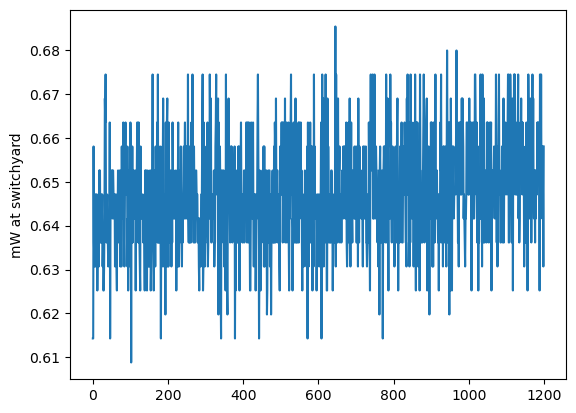

In [47]:
# plot the photodiode voltage and counts. produce same number of figures as above

minpd = min(pd_data)
maxpd = max(pd_data)
V_to_mW = lambda x: -0.195395 + 17.9214 * (x + 0.011)  # this accounts for a mismatch between what the Sampler reads and what
            # the multimeter that I used for the fit reads
            
fig,ax = plt.subplots()
# for i in range(len(counts)//(xsteps*ysteps*ncols*nrows)):
#     fig,axes = plt.subplots(nrows=2,ncols=1,sharex=True)
#     ax,ax2 = axes
#     imin = i*nrows*ncols*xsteps*ysteps
#     imax = (i+1)*nrows*ncols*xsteps*ysteps
ax.plot(V_to_mW(pd_data))
# ax.set_ylim((mincounts,maxcounts))
#     ax.set_ylabel("SPCM counts")
#     ax2.plot(pd_data[imin:imax])
#     ax2.set_ylim((minpd,maxpd))
# ax.set_ylabel("PD voltage")
ax.set_ylabel("mW at switchyard")

#     ax.set_title(f"steps i0={imin} to if={imax}")
#     ax2.set_xlabel("steps + i0")
#     plt.savefig(datafile[:-4] + '_counts_and_pd_' + str(i) + '.png', bbox_inches='tight')
#     plt.close()

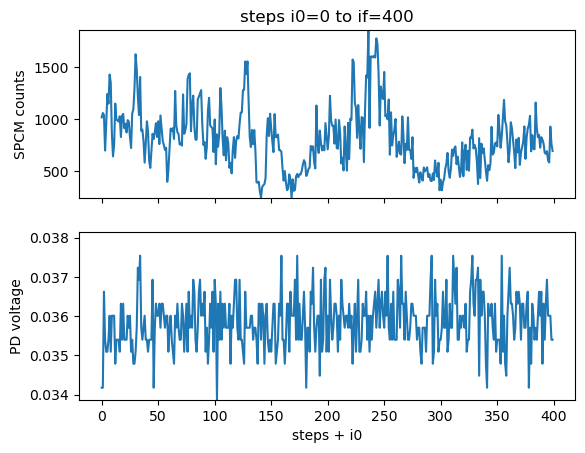

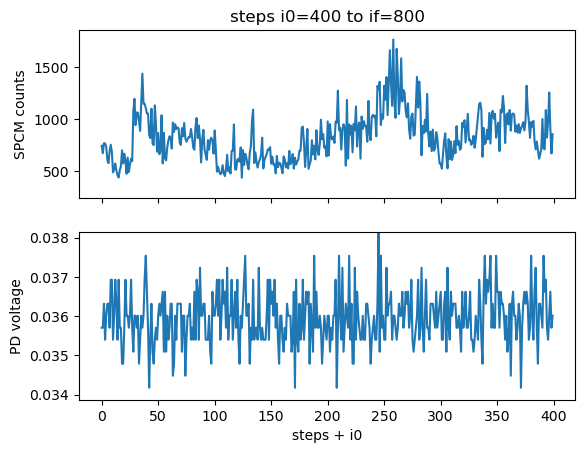

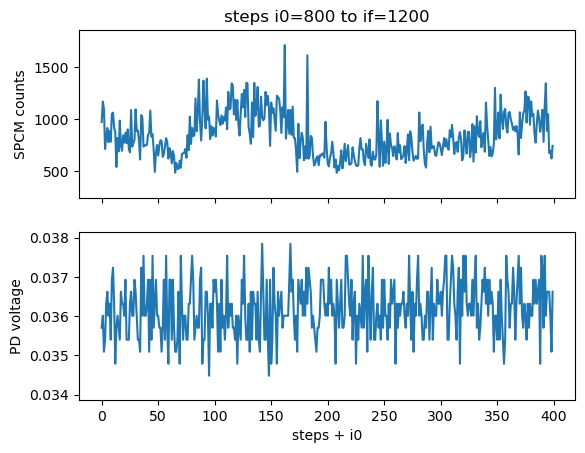

In [45]:
# plot the photodiode voltage and counts. produce same number of figures as above

minpd = min(pd_data)
maxpd = max(pd_data)
for i in range(len(counts)//(xsteps*ysteps*ncols*nrows)):
    fig,axes = plt.subplots(nrows=2,ncols=1,sharex=True)
    ax,ax2 = axes
    imin = i*nrows*ncols*xsteps*ysteps
    imax = (i+1)*nrows*ncols*xsteps*ysteps
    ax.plot(counts[imin:imax])
    ax.set_ylim((mincounts,maxcounts))
    ax.set_ylabel("SPCM counts")
    ax2.plot(pd_data[imin:imax])
    ax2.set_ylim((minpd,maxpd))
    ax2.set_ylabel("PD voltage")
    ax.set_title(f"steps i0={imin} to if={imax}")
    ax2.set_xlabel("steps + i0")
#     plt.savefig(datafile[:-4] + '_counts_and_pd_' + str(i) + '.png', bbox_inches='tight')
#     plt.close()

maxidx=18734, maxct=532.0, Vpd=0.0384521484375
coil VZbottom, VZtop, VX, VY = (0.72, -1.68, -0.61, -0.6225)


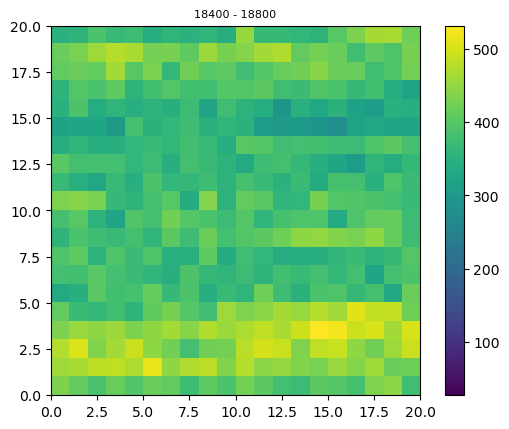

In [219]:
# find the max counts index then print out the coil settings and PD reading

maxct, maxidx = get_max_idx(counts)

print(f"maxidx={maxidx}, maxct={maxct}, Vpd={pd_data[maxidx]}")
print(f"coil VZbottom, VZtop, VX, VY = {zbottom_data[maxidx], ztop_data[maxidx], xdata[maxidx], ydata[maxidx]}")

step0 = xsteps*ysteps*(maxidx//(xsteps*ysteps))

fig,ax = plt.subplots()

imdata = counts[step0:step0+xsteps*ysteps].reshape((xsteps,ysteps))

im = ax.imshow(imdata, extent=[ymin, ymax, xmin, xmax], vmin=mincounts, vmax=maxcounts)
ax.set_aspect((ymax-ymin)/(xmax-xmin))
ax.set_title(f"{step0} - {step0+xsteps*ysteps}",fontsize=8)
fig.colorbar(im)

maxidx=41321, maxct=1055.0, Vpd=0.03936767578125
coil VZbottom, VZtop, VX, VY = (0.9199999999999999, -2.76, -0.13500000000000004, -0.021249999999999998)


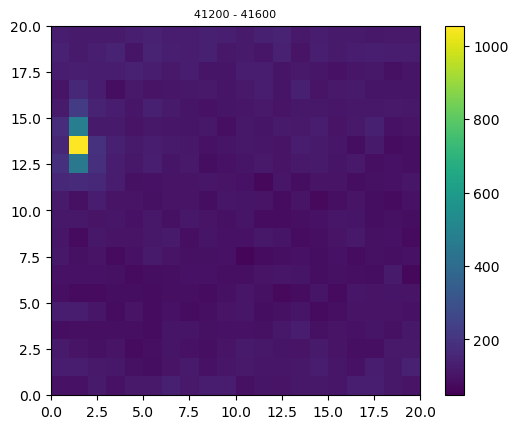

In [43]:
# local max for a given step range
step0 = xsteps*ysteps*(41200//(xsteps*ysteps)) #33600 # start here, as motivating by looking at the images we saved

fig,ax = plt.subplots()

imdata = counts[step0:step0+xsteps*ysteps].reshape((xsteps,ysteps))
maxct,maxidx = get_max_idx(counts[step0:step0+xsteps*ysteps])
maxidx += step0
print(f"maxidx={maxidx}, maxct={maxct}, Vpd={pd_data[maxidx]}")
print(f"coil VZbottom, VZtop, VX, VY = {zbottom_data[maxidx], ztop_data[maxidx], xdata[maxidx], ydata[maxidx]}")

im = ax.imshow(imdata, extent=[ymin, ymax, xmin, xmax], vmin=mincounts, vmax=maxcounts)
ax.set_aspect((ymax-ymin)/(xmax-xmin))
ax.set_title(f"{step0} - {step0+xsteps*ysteps}",fontsize=8)
fig.colorbar(im)

#### 2023.08.25
The scan code is working but I don't think there was a MOT at any time. I had just implemented the MOT feedback with the fW detector, so there may have been a bug or the fluctuations in beam powers was too large.

In [3]:
datafile = os.path.join(expdir,"results\\20230825_203415_coil_scan.csv")


has_header = True
with open(datafile, 'r', newline='') as f:
    reader = csv.reader(f)
    if has_header:
        header = reader.__next__()
    data = [row for row in reader]#[:5]
    f.close()

data = np.array(data,float).transpose()
# print(data)
rows,cols = data.shape

In [4]:
counts = data[0]
pd_data = data[-1] # the cooling laser power monitor
coil_data = data[1:-1]#[:12800] # just as a check. should make two figures

zbottom_data, ztop_data, xdata, ydata = coil_data

zbottom_steps = len(list(set(zbottom_data)))
ztop_steps = len(list(set(zbottom_data)))
xsteps = len(list(set(xdata)))
ysteps = len(list(set(ydata)))

In [6]:
### nrows and ncols are the number of subplots in each image
nrows = 4
ncols = 5
assert nrows * ncols == zbottom_steps, f"the number of subplots should be zbottom_steps={zbottom_steps}"

In [7]:
k = l = 0
ysteps*xsteps*zbottom_steps*k + l*ysteps*xsteps
xsteps*ysteps

400

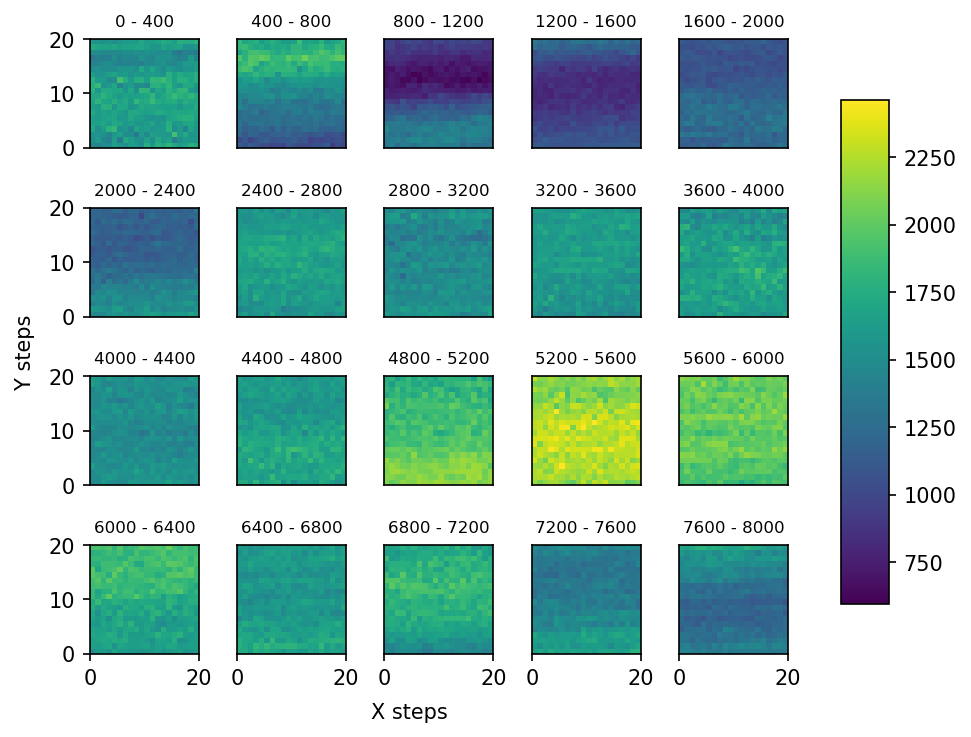

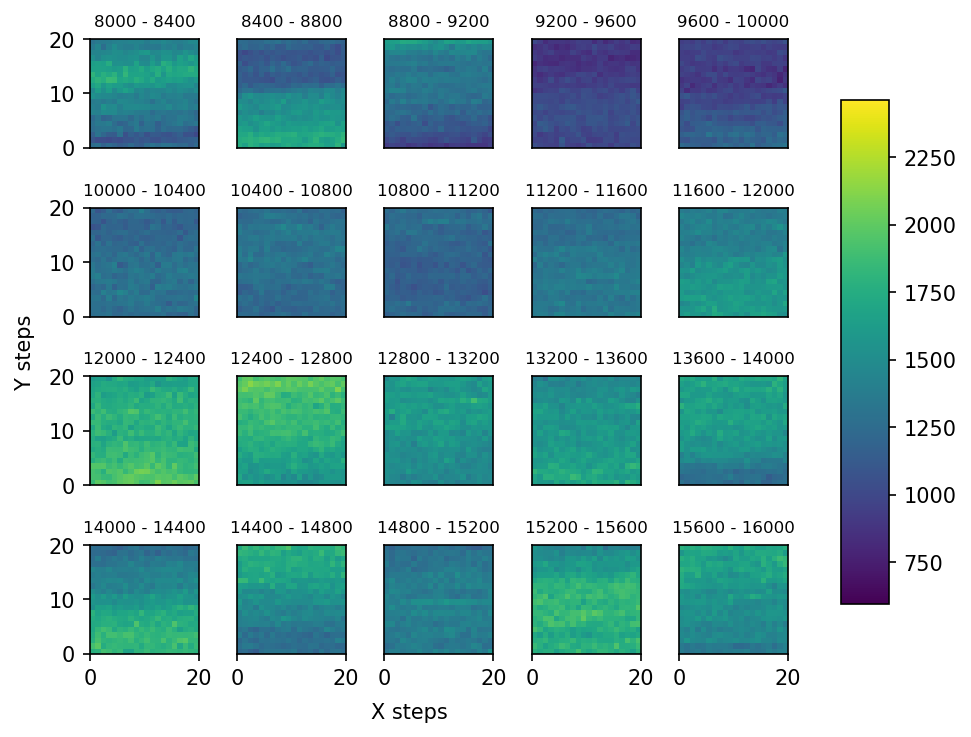

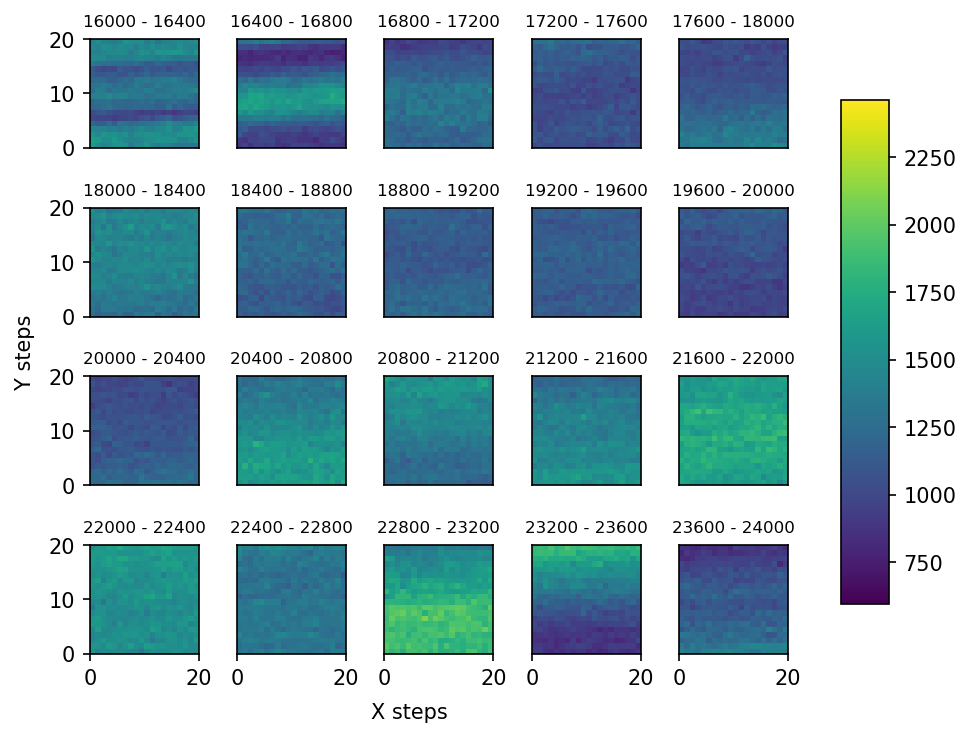

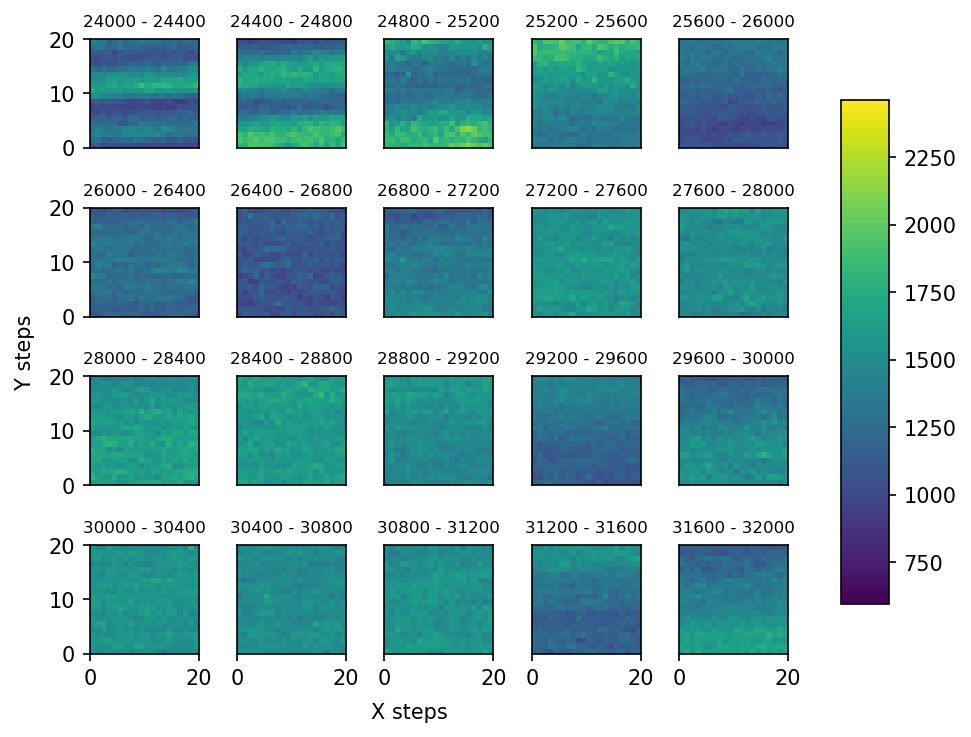

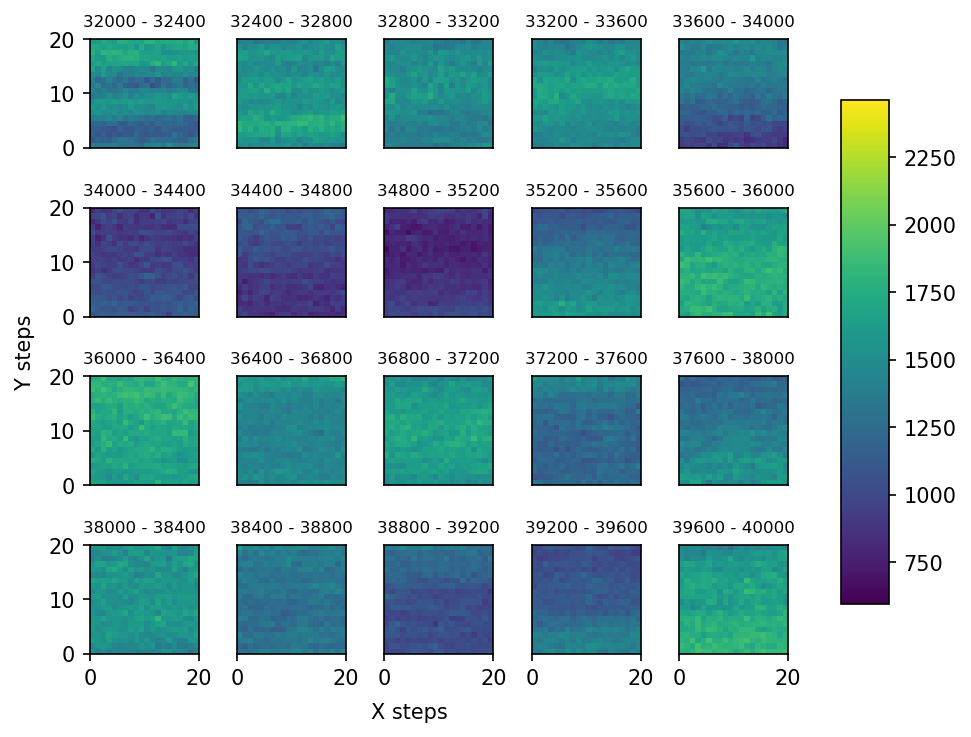

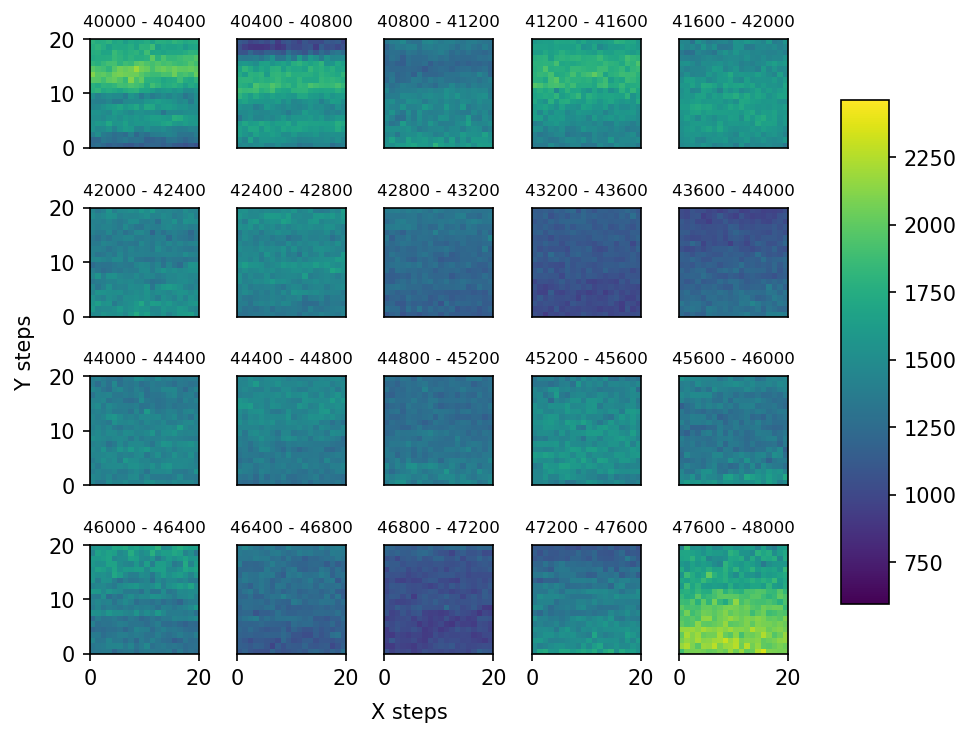

ValueError: cannot reshape array of size 174 into shape (20,20)

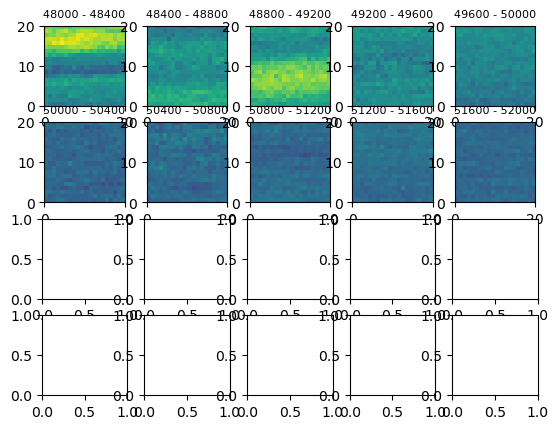

In [8]:
# this plotting procedure assumes that the order of the loops is ztop, zbottom, x, y

ymin = xmin = 0
xmax = ymax = xsteps # assumes ysteps = xsteps

maxcounts = max(counts)
mincounts = min(counts)

for k in range(ztop_steps):
    
    # one figure for each ztop step. each will contain one subplot for each zbottom step
    fig, axes = plt.subplots(nrows=nrows,ncols=ncols)
    
    for l,ax in enumerate(axes.flat):

#         ztop_step = k*ncols + col
#         zbottom_step = l*nrows + row

        # the step where we start counting from to get the counts at x and y steps
        # for the kth ztop step and lth zbottom step
        step0 = ysteps*xsteps*zbottom_steps*k + l*ysteps*xsteps

        imdata = counts[step0:step0+xsteps*ysteps].reshape((xsteps,ysteps))

        im = ax.imshow(imdata, extent=[ymin, ymax, xmin, xmax], vmin=mincounts, vmax=maxcounts)
        ax.set_aspect((ymax-ymin)/(xmax-xmin))
        ax.set_title(f"{step0} - {step0+xsteps*ysteps}",fontsize=8)

#         if col > 0:
#             ax.set_yticks([])
#         if row < 3:
#             ax.set_xticks([])

    # turn off redundant axes ticks
    if nrows > 1:
        [ax.set_xticks([]) for ax in axes[:-1,:].flat]
        [ax.set_yticks([]) for ax in axes[:,1:].flat]
    else:
        pass

    fig.tight_layout()
    fig.subplots_adjust(right=0.8)
    cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
    fig.colorbar(im, cax=cbar_ax)

    fig.text(0.4, 0, 'X steps', ha='center', va='center')
    fig.text(-0.0, 0.5, 'Y steps', ha='center', va='center', rotation='vertical')
    fig.dpi = 150
#         plt.savefig(datafile[:-4] + '_3D_' + str(k*(1+ncols) + l) + '.png', bbox_inches='tight')
#         plt.close()
    plt.show()

#     break

maxidx=48084, maxct=2448.0, Vpd=-0.0140380859375
coil VZbottom, VZtop, VX, VY = (6.0, 7.35, -0.3, -0.3)


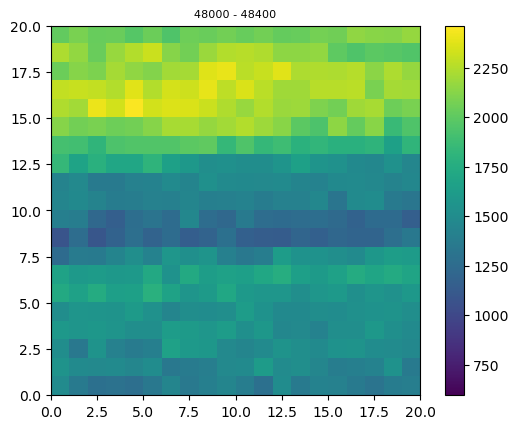

In [9]:
# local max for a given step range
step0 = 48000 #xsteps*ysteps*(200//(xsteps*ysteps)) #33600 # start here, as motivating by looking at the images we saved

fig,ax = plt.subplots()

imdata = counts[step0:step0+xsteps*ysteps].reshape((xsteps,ysteps))
maxct,maxidx = get_max_idx(counts[step0:step0+xsteps*ysteps])
maxidx += step0
print(f"maxidx={maxidx}, maxct={maxct}, Vpd={pd_data[maxidx]}")
print(f"coil VZbottom, VZtop, VX, VY = {zbottom_data[maxidx], ztop_data[maxidx], xdata[maxidx], ydata[maxidx]}")

im = ax.imshow(imdata, extent=[ymin, ymax, xmin, xmax], vmin=mincounts, vmax=maxcounts)
ax.set_aspect((ymax-ymin)/(xmax-xmin))
ax.set_title(f"{step0} - {step0+xsteps*ysteps}",fontsize=8)
fig.colorbar(im)

IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

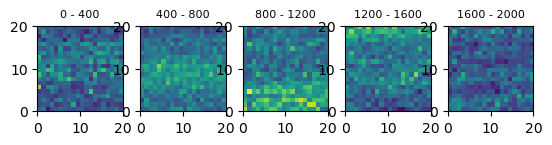

In [12]:
# this plotting procedure assumes that the order of the loops is ztop, zbottom, x, yb

ymin = xmin = 0
xmax = ymax = xsteps # assumes ysteps = xsteps

maxcounts = max(counts)
mincounts = min(counts)

for k in range(ztop_steps):
    
    # one figure for each ztop step. each will contain one subplot for each zbottom step
    fig, axes = plt.subplots(nrows=nrows,ncols=ncols)
    
    for l,ax in enumerate(axes.flat):

#         ztop_step = k*ncols + col
#         zbottom_step = l*nrows + row

        # the step where we start counting from to get the counts at x and y steps
        # for the kth ztop step and lth zbottom step
        step0 = ysteps*xsteps*zbottom_steps*k + l*ysteps*xsteps

        imdata = counts[step0:step0+xsteps*ysteps].reshape((xsteps,ysteps))

        im = ax.imshow(imdata, extent=[ymin, ymax, xmin, xmax], vmin=mincounts, vmax=maxcounts)
        ax.set_aspect((ymax-ymin)/(xmax-xmin))
        ax.set_title(f"{step0} - {step0+xsteps*ysteps}",fontsize=8)

#         if col > 0:
#             ax.set_yticks([])
#         if row < 3:
#             ax.set_xticks([])

    # turn off redundant axes ticks
    [ax.set_xticks([]) for ax in axes[:-1,:].flat]
    [ax.set_yticks([]) for ax in axes[:,1:].flat]

    fig.tight_layout()
    fig.subplots_adjust(right=0.8)
    cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
    fig.colorbar(im, cax=cbar_ax)

    fig.text(0.4, 0, 'X steps', ha='center', va='center')
    fig.text(-0.0, 0.5, 'Y steps', ha='center', va='center', rotation='vertical')
    fig.dpi = 150
#         plt.savefig(datafile[:-4] + '_3D_' + str(k*(1+ncols) + l) + '.png', bbox_inches='tight')
#         plt.close()
    plt.show()

#     break

Text(0, 0.5, 'mW at switchyard')

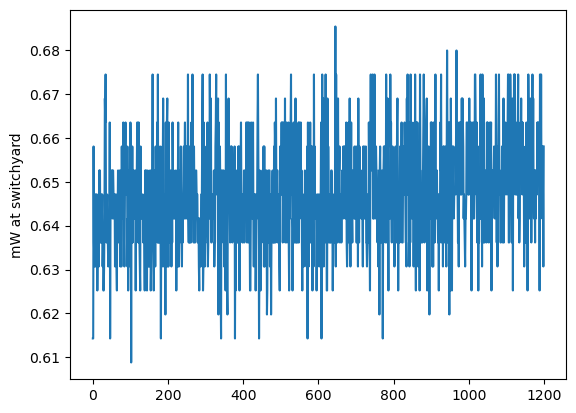

In [47]:
# plot the photodiode voltage and counts. produce same number of figures as above

minpd = min(pd_data)
maxpd = max(pd_data)
V_to_mW = lambda x: -0.195395 + 17.9214 * (x + 0.011)  # this accounts for a mismatch between what the Sampler reads and what
            # the multimeter that I used for the fit reads
            
fig,ax = plt.subplots()
# for i in range(len(counts)//(xsteps*ysteps*ncols*nrows)):
#     fig,axes = plt.subplots(nrows=2,ncols=1,sharex=True)
#     ax,ax2 = axes
#     imin = i*nrows*ncols*xsteps*ysteps
#     imax = (i+1)*nrows*ncols*xsteps*ysteps
ax.plot(V_to_mW(pd_data))
# ax.set_ylim((mincounts,maxcounts))
#     ax.set_ylabel("SPCM counts")
#     ax2.plot(pd_data[imin:imax])
#     ax2.set_ylim((minpd,maxpd))
# ax.set_ylabel("PD voltage")
ax.set_ylabel("mW at switchyard")

#     ax.set_title(f"steps i0={imin} to if={imax}")
#     ax2.set_xlabel("steps + i0")
#     plt.savefig(datafile[:-4] + '_counts_and_pd_' + str(i) + '.png', bbox_inches='tight')
#     plt.close()

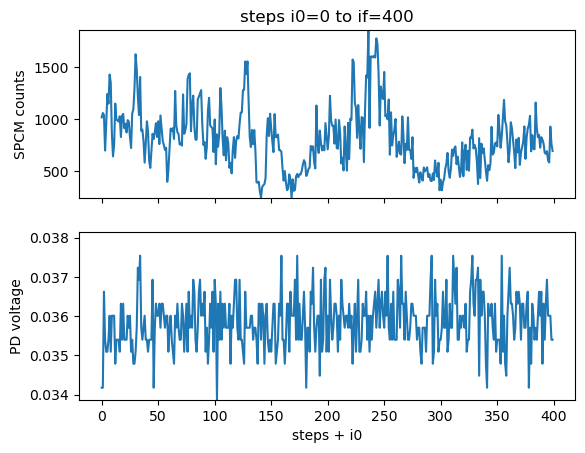

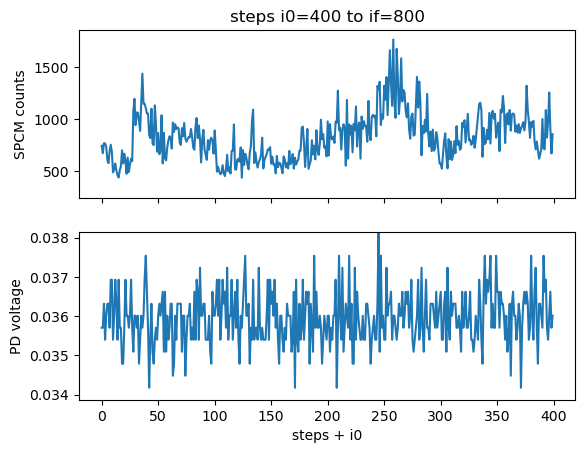

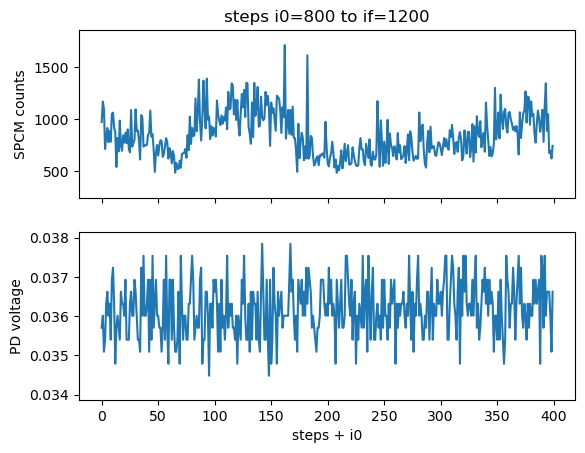

In [45]:
# plot the photodiode voltage and counts. produce same number of figures as above

minpd = min(pd_data)
maxpd = max(pd_data)
for i in range(len(counts)//(xsteps*ysteps*ncols*nrows)):
    fig,axes = plt.subplots(nrows=2,ncols=1,sharex=True)
    ax,ax2 = axes
    imin = i*nrows*ncols*xsteps*ysteps
    imax = (i+1)*nrows*ncols*xsteps*ysteps
    ax.plot(counts[imin:imax])
    ax.set_ylim((mincounts,maxcounts))
    ax.set_ylabel("SPCM counts")
    ax2.plot(pd_data[imin:imax])
    ax2.set_ylim((minpd,maxpd))
    ax2.set_ylabel("PD voltage")
    ax.set_title(f"steps i0={imin} to if={imax}")
    ax2.set_xlabel("steps + i0")
#     plt.savefig(datafile[:-4] + '_counts_and_pd_' + str(i) + '.png', bbox_inches='tight')
#     plt.close()

maxidx=18734, maxct=532.0, Vpd=0.0384521484375
coil VZbottom, VZtop, VX, VY = (0.72, -1.68, -0.61, -0.6225)


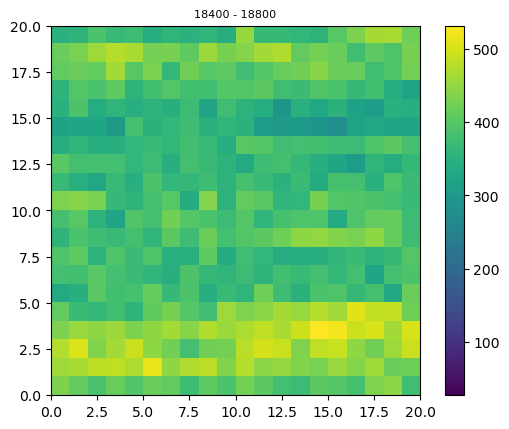

In [219]:
# find the max counts index then print out the coil settings and PD reading

maxct, maxidx = get_max_idx(counts)

print(f"maxidx={maxidx}, maxct={maxct}, Vpd={pd_data[maxidx]}")
print(f"coil VZbottom, VZtop, VX, VY = {zbottom_data[maxidx], ztop_data[maxidx], xdata[maxidx], ydata[maxidx]}")

step0 = xsteps*ysteps*(maxidx//(xsteps*ysteps))

fig,ax = plt.subplots()

imdata = counts[step0:step0+xsteps*ysteps].reshape((xsteps,ysteps))

im = ax.imshow(imdata, extent=[ymin, ymax, xmin, xmax], vmin=mincounts, vmax=maxcounts)
ax.set_aspect((ymax-ymin)/(xmax-xmin))
ax.set_title(f"{step0} - {step0+xsteps*ysteps}",fontsize=8)
fig.colorbar(im)

maxidx=41321, maxct=1055.0, Vpd=0.03936767578125
coil VZbottom, VZtop, VX, VY = (0.9199999999999999, -2.76, -0.13500000000000004, -0.021249999999999998)


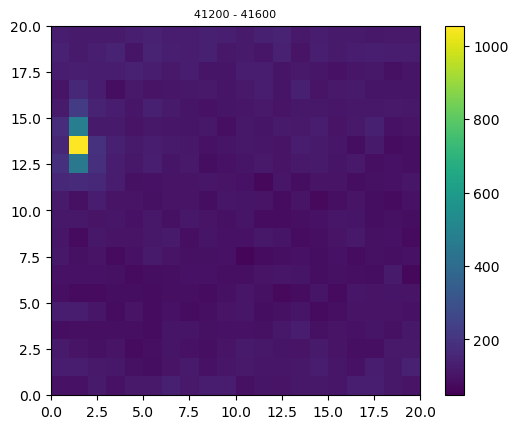

In [43]:
# local max for a given step range
step0 = xsteps*ysteps*(41200//(xsteps*ysteps)) #33600 # start here, as motivating by looking at the images we saved

fig,ax = plt.subplots()

imdata = counts[step0:step0+xsteps*ysteps].reshape((xsteps,ysteps))
maxct,maxidx = get_max_idx(counts[step0:step0+xsteps*ysteps])
maxidx += step0
print(f"maxidx={maxidx}, maxct={maxct}, Vpd={pd_data[maxidx]}")
print(f"coil VZbottom, VZtop, VX, VY = {zbottom_data[maxidx], ztop_data[maxidx], xdata[maxidx], ydata[maxidx]}")

im = ax.imshow(imdata, extent=[ymin, ymax, xmin, xmax], vmin=mincounts, vmax=maxcounts)
ax.set_aspect((ymax-ymin)/(xmax-xmin))
ax.set_title(f"{step0} - {step0+xsteps*ysteps}",fontsize=8)
fig.colorbar(im)

### May-June 2023

In [9]:
# datafile = os.path.join(expdir,"20230506_163411_coil_scan.csv")
# datafile = os.path.join(expdir,"20230516_202753_coil_scan.csv")
datafile = os.path.join(expdir,"20230517_082908_coil_scan.csv") # very clear SPCM signal
# datafile = os.path.join(expdir,"20230519_114212_coil_scan.csv") # very clear SPCM signal
# datafile = os.path.join(expdir,"20230605_114258_coil_scan.csv")


has_header = True
with open(datafile, 'r', newline='') as f:
    reader = csv.reader(f)
    if has_header:
        header = reader.__next__()
    data = [row for row in reader]#[:5]
    f.close()

data = np.array(data,float).transpose()
# print(data)
rows,cols = data.shape

In [10]:
counts = data[0]
pd_data = data[-1] # the cooling laser power monitor
coil_data = data[1:-1]#[:12800] # just as a check. should make two figures

zbottom_data, ztop_data, xdata, ydata = coil_data

zbottom_steps = len(list(set(zbottom_data)))
ztop_steps = len(list(set(zbottom_data)))
xsteps = len(list(set(xdata)))
ysteps = len(list(set(ydata)))

In [12]:
### nrows and ncols are the number of subplots in each image
nrows = 4
ncols = 5
assert nrows * ncols == zbottom_steps, f"the number of subplots should be zbottom_steps={zbottom_steps}"

In [13]:
k = l = 0
ysteps*xsteps*zbottom_steps*k + l*ysteps*xsteps
xsteps*ysteps

400

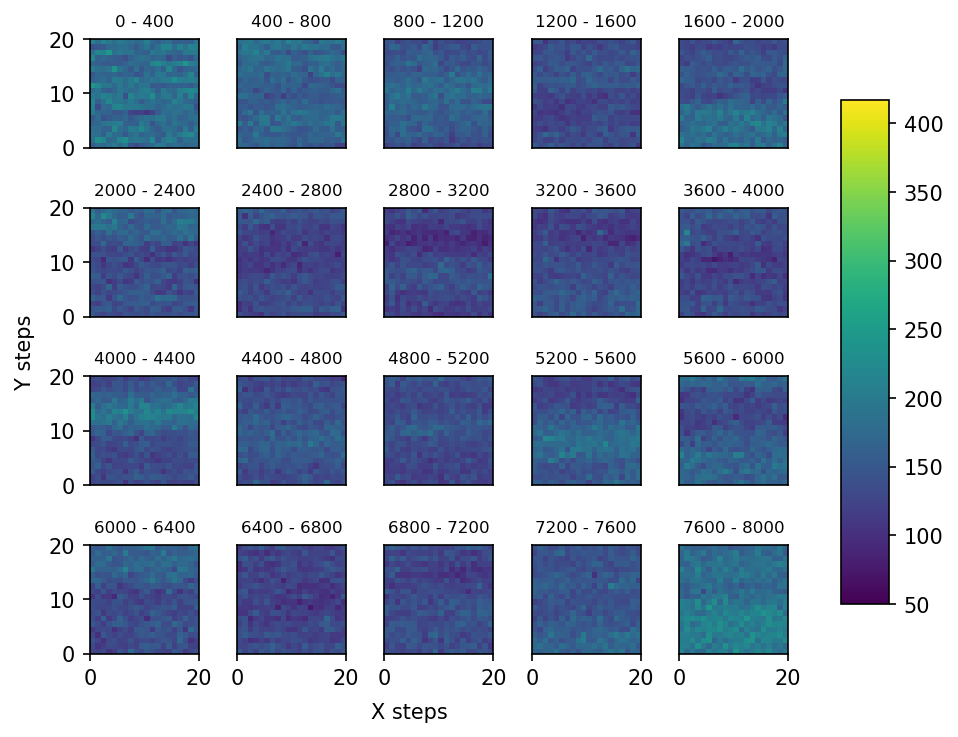

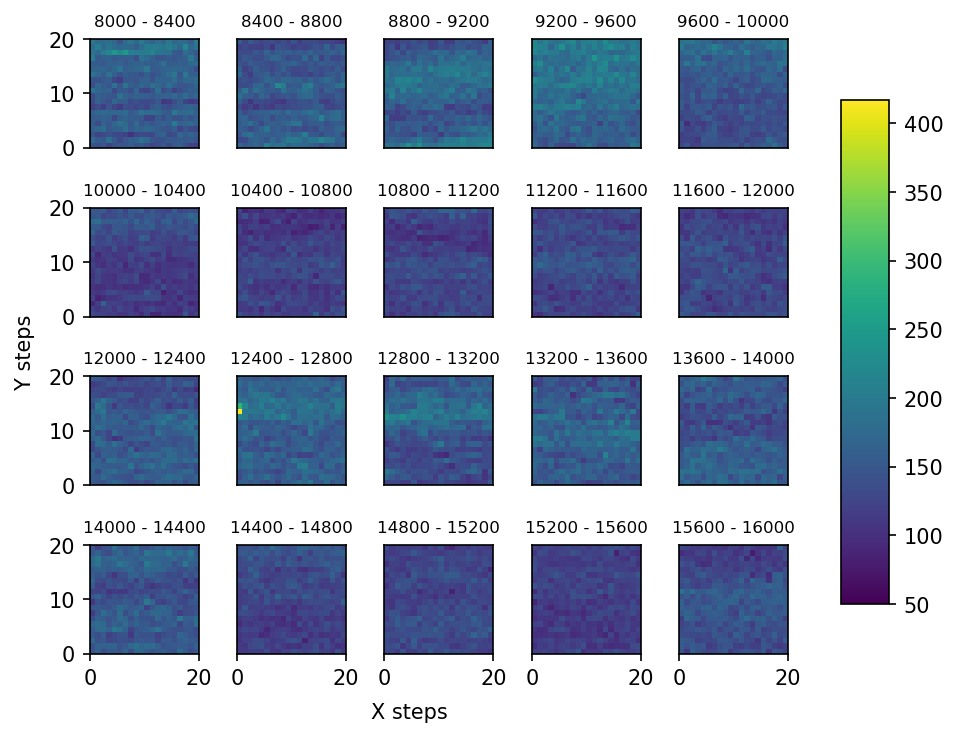

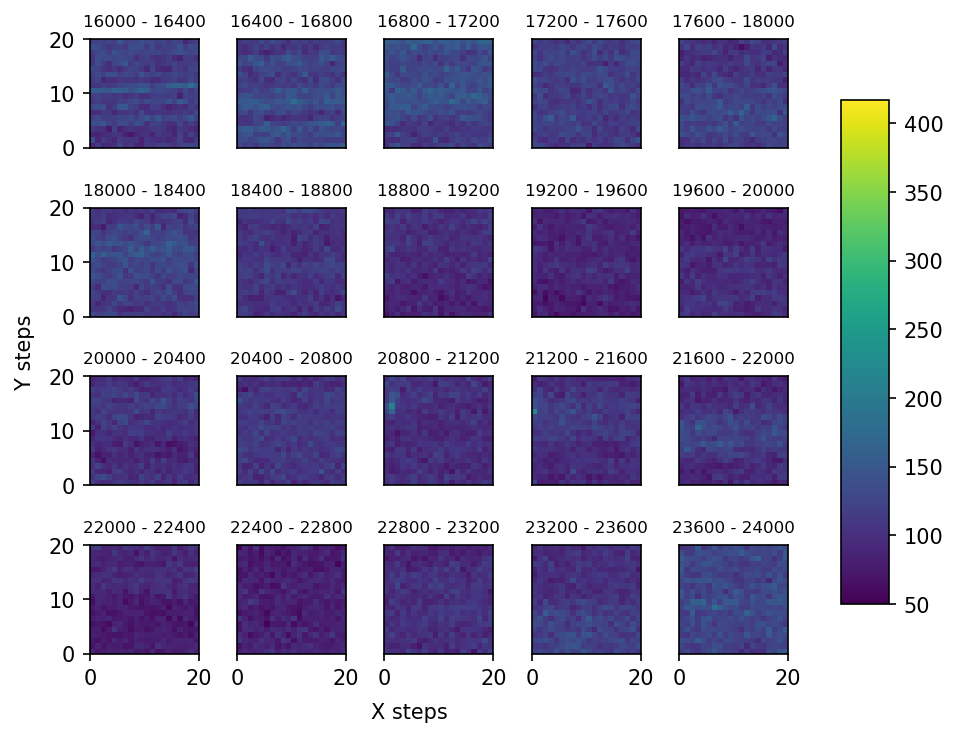

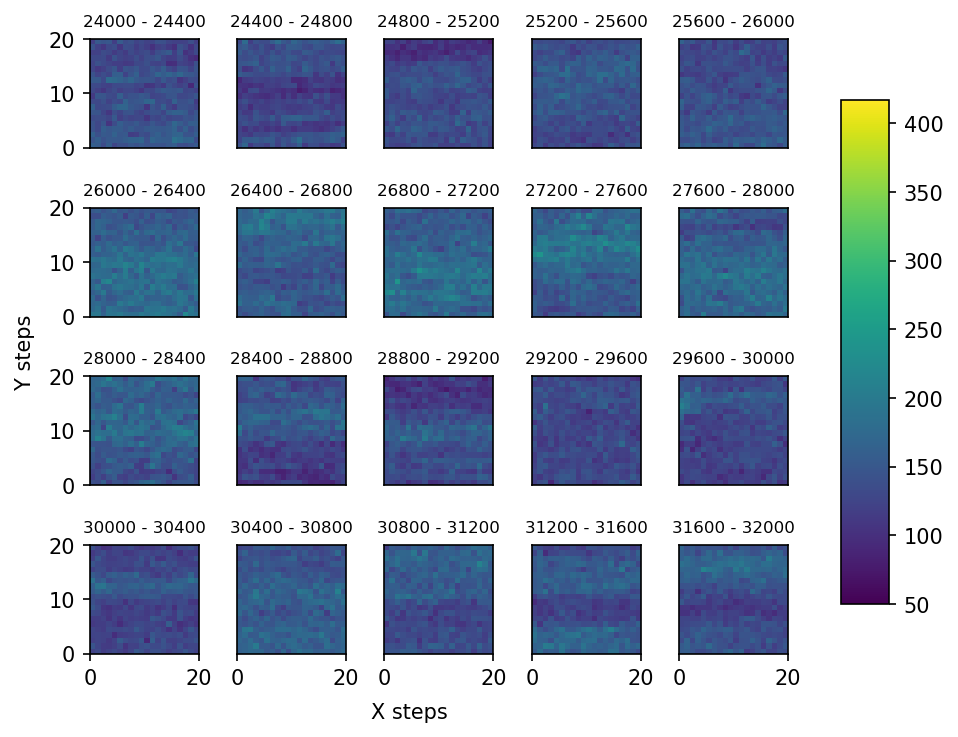

ValueError: cannot reshape array of size 361 into shape (20,20)

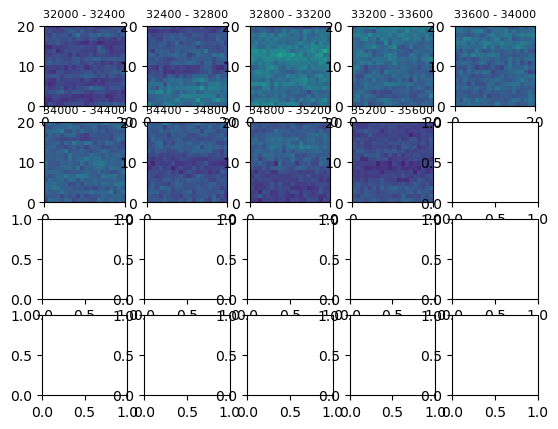

In [14]:
# this plotting procedure assumes that the order of the loops is ztop, zbottom, x, y

ymin = xmin = 0
xmax = ymax = xsteps # assumes ysteps = xsteps

maxcounts = max(counts)
mincounts = min(counts)

for k in range(ztop_steps):
    
    # one figure for each ztop step. each will contain one subplot for each zbottom step
    fig, axes = plt.subplots(nrows=nrows,ncols=ncols)
    
    for l,ax in enumerate(axes.flat):

#         ztop_step = k*ncols + col
#         zbottom_step = l*nrows + row

        # the step where we start counting from to get the counts at x and y steps
        # for the kth ztop step and lth zbottom step
        step0 = ysteps*xsteps*zbottom_steps*k + l*ysteps*xsteps

        imdata = counts[step0:step0+xsteps*ysteps].reshape((xsteps,ysteps))

        im = ax.imshow(imdata, extent=[ymin, ymax, xmin, xmax], vmin=mincounts, vmax=maxcounts)
        ax.set_aspect((ymax-ymin)/(xmax-xmin))
        ax.set_title(f"{step0} - {step0+xsteps*ysteps}",fontsize=8)

#         if col > 0:
#             ax.set_yticks([])
#         if row < 3:
#             ax.set_xticks([])

    # turn off redundant axes ticks
    if nrows > 1:
        [ax.set_xticks([]) for ax in axes[:-1,:].flat]
        [ax.set_yticks([]) for ax in axes[:,1:].flat]
    else:
        pass

    fig.tight_layout()
    fig.subplots_adjust(right=0.8)
    cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
    fig.colorbar(im, cax=cbar_ax)

    fig.text(0.4, 0, 'X steps', ha='center', va='center')
    fig.text(-0.0, 0.5, 'Y steps', ha='center', va='center', rotation='vertical')
    fig.dpi = 150
#         plt.savefig(datafile[:-4] + '_3D_' + str(k*(1+ncols) + l) + '.png', bbox_inches='tight')
#         plt.close()
    plt.show()

#     break

In [29]:
print(ztop_steps)

4


maxidx=236, maxct=1852.0, Vpd=0.0360107421875
coil VZbottom, VZtop, VX, VY = (1.1, -2.8600000000000003, -0.17142857142857146, -0.27)


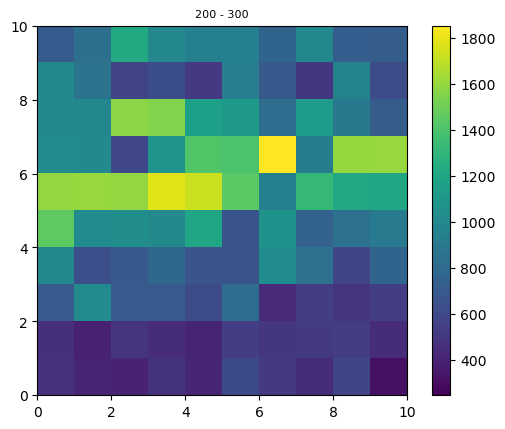

In [35]:
# local max for a given step range
step0 = xsteps*ysteps*(200//(xsteps*ysteps)) #33600 # start here, as motivating by looking at the images we saved

fig,ax = plt.subplots()

imdata = counts[step0:step0+xsteps*ysteps].reshape((xsteps,ysteps))
maxct,maxidx = get_max_idx(counts[step0:step0+xsteps*ysteps])
maxidx += step0
print(f"maxidx={maxidx}, maxct={maxct}, Vpd={pd_data[maxidx]}")
print(f"coil VZbottom, VZtop, VX, VY = {zbottom_data[maxidx], ztop_data[maxidx], xdata[maxidx], ydata[maxidx]}")

im = ax.imshow(imdata, extent=[ymin, ymax, xmin, xmax], vmin=mincounts, vmax=maxcounts)
ax.set_aspect((ymax-ymin)/(xmax-xmin))
ax.set_title(f"{step0} - {step0+xsteps*ysteps}",fontsize=8)
fig.colorbar(im)

IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

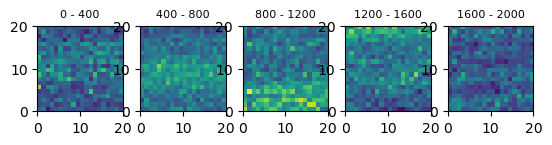

In [12]:
# this plotting procedure assumes that the order of the loops is ztop, zbottom, x, yb

ymin = xmin = 0
xmax = ymax = xsteps # assumes ysteps = xsteps

maxcounts = max(counts)
mincounts = min(counts)

for k in range(ztop_steps):
    
    # one figure for each ztop step. each will contain one subplot for each zbottom step
    fig, axes = plt.subplots(nrows=nrows,ncols=ncols)
    
    for l,ax in enumerate(axes.flat):

#         ztop_step = k*ncols + col
#         zbottom_step = l*nrows + row

        # the step where we start counting from to get the counts at x and y steps
        # for the kth ztop step and lth zbottom step
        step0 = ysteps*xsteps*zbottom_steps*k + l*ysteps*xsteps

        imdata = counts[step0:step0+xsteps*ysteps].reshape((xsteps,ysteps))

        im = ax.imshow(imdata, extent=[ymin, ymax, xmin, xmax], vmin=mincounts, vmax=maxcounts)
        ax.set_aspect((ymax-ymin)/(xmax-xmin))
        ax.set_title(f"{step0} - {step0+xsteps*ysteps}",fontsize=8)

#         if col > 0:
#             ax.set_yticks([])
#         if row < 3:
#             ax.set_xticks([])

    # turn off redundant axes ticks
    [ax.set_xticks([]) for ax in axes[:-1,:].flat]
    [ax.set_yticks([]) for ax in axes[:,1:].flat]

    fig.tight_layout()
    fig.subplots_adjust(right=0.8)
    cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
    fig.colorbar(im, cax=cbar_ax)

    fig.text(0.4, 0, 'X steps', ha='center', va='center')
    fig.text(-0.0, 0.5, 'Y steps', ha='center', va='center', rotation='vertical')
    fig.dpi = 150
#         plt.savefig(datafile[:-4] + '_3D_' + str(k*(1+ncols) + l) + '.png', bbox_inches='tight')
#         plt.close()
    plt.show()

#     break

Text(0, 0.5, 'mW at switchyard')

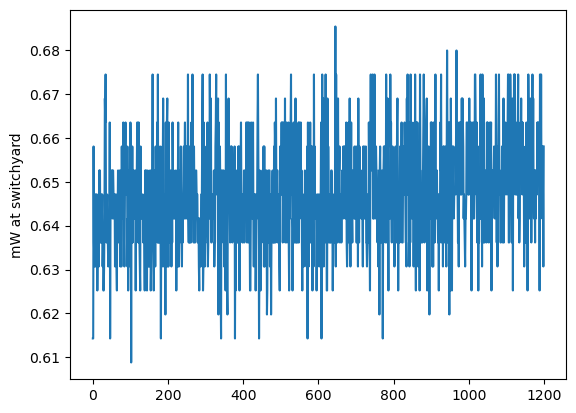

In [47]:
# plot the photodiode voltage and counts. produce same number of figures as above

minpd = min(pd_data)
maxpd = max(pd_data)
V_to_mW = lambda x: -0.195395 + 17.9214 * (x + 0.011)  # this accounts for a mismatch between what the Sampler reads and what
            # the multimeter that I used for the fit reads
            
fig,ax = plt.subplots()
# for i in range(len(counts)//(xsteps*ysteps*ncols*nrows)):
#     fig,axes = plt.subplots(nrows=2,ncols=1,sharex=True)
#     ax,ax2 = axes
#     imin = i*nrows*ncols*xsteps*ysteps
#     imax = (i+1)*nrows*ncols*xsteps*ysteps
ax.plot(V_to_mW(pd_data))
# ax.set_ylim((mincounts,maxcounts))
#     ax.set_ylabel("SPCM counts")
#     ax2.plot(pd_data[imin:imax])
#     ax2.set_ylim((minpd,maxpd))
# ax.set_ylabel("PD voltage")
ax.set_ylabel("mW at switchyard")

#     ax.set_title(f"steps i0={imin} to if={imax}")
#     ax2.set_xlabel("steps + i0")
#     plt.savefig(datafile[:-4] + '_counts_and_pd_' + str(i) + '.png', bbox_inches='tight')
#     plt.close()

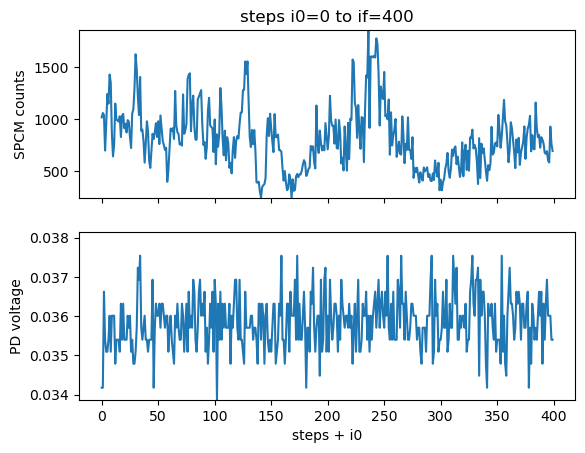

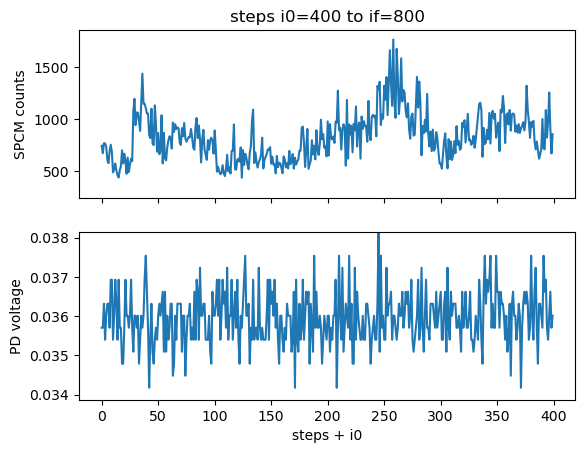

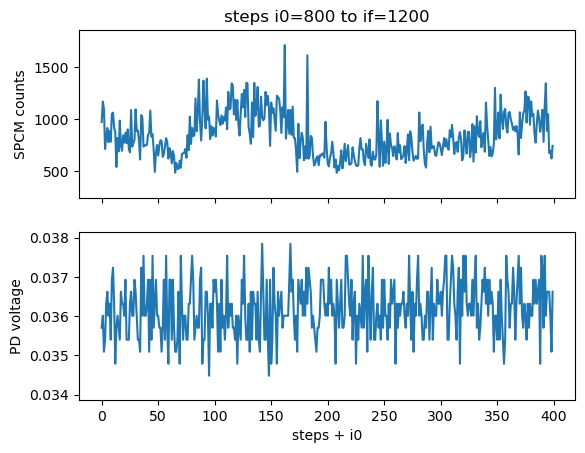

In [45]:
# plot the photodiode voltage and counts. produce same number of figures as above

minpd = min(pd_data)
maxpd = max(pd_data)
for i in range(len(counts)//(xsteps*ysteps*ncols*nrows)):
    fig,axes = plt.subplots(nrows=2,ncols=1,sharex=True)
    ax,ax2 = axes
    imin = i*nrows*ncols*xsteps*ysteps
    imax = (i+1)*nrows*ncols*xsteps*ysteps
    ax.plot(counts[imin:imax])
    ax.set_ylim((mincounts,maxcounts))
    ax.set_ylabel("SPCM counts")
    ax2.plot(pd_data[imin:imax])
    ax2.set_ylim((minpd,maxpd))
    ax2.set_ylabel("PD voltage")
    ax.set_title(f"steps i0={imin} to if={imax}")
    ax2.set_xlabel("steps + i0")
#     plt.savefig(datafile[:-4] + '_counts_and_pd_' + str(i) + '.png', bbox_inches='tight')
#     plt.close()

maxidx=18734, maxct=532.0, Vpd=0.0384521484375
coil VZbottom, VZtop, VX, VY = (0.72, -1.68, -0.61, -0.6225)


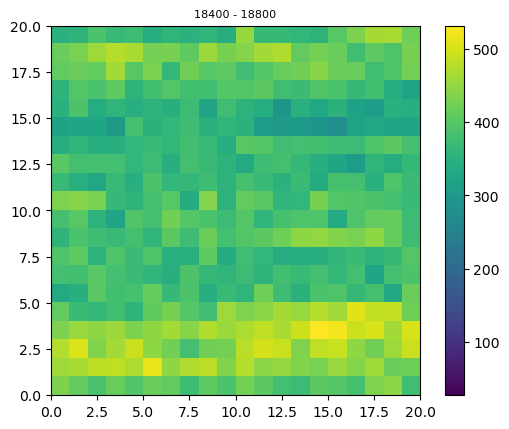

In [219]:
# find the max counts index then print out the coil settings and PD reading

maxct, maxidx = get_max_idx(counts)

print(f"maxidx={maxidx}, maxct={maxct}, Vpd={pd_data[maxidx]}")
print(f"coil VZbottom, VZtop, VX, VY = {zbottom_data[maxidx], ztop_data[maxidx], xdata[maxidx], ydata[maxidx]}")

step0 = xsteps*ysteps*(maxidx//(xsteps*ysteps))

fig,ax = plt.subplots()

imdata = counts[step0:step0+xsteps*ysteps].reshape((xsteps,ysteps))

im = ax.imshow(imdata, extent=[ymin, ymax, xmin, xmax], vmin=mincounts, vmax=maxcounts)
ax.set_aspect((ymax-ymin)/(xmax-xmin))
ax.set_title(f"{step0} - {step0+xsteps*ysteps}",fontsize=8)
fig.colorbar(im)

maxidx=41321, maxct=1055.0, Vpd=0.03936767578125
coil VZbottom, VZtop, VX, VY = (0.9199999999999999, -2.76, -0.13500000000000004, -0.021249999999999998)


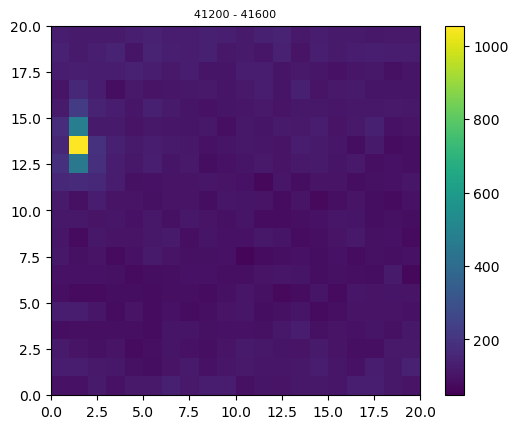

In [43]:
# local max for a given step range
step0 = xsteps*ysteps*(41200//(xsteps*ysteps)) #33600 # start here, as motivating by looking at the images we saved

fig,ax = plt.subplots()

imdata = counts[step0:step0+xsteps*ysteps].reshape((xsteps,ysteps))
maxct,maxidx = get_max_idx(counts[step0:step0+xsteps*ysteps])
maxidx += step0
print(f"maxidx={maxidx}, maxct={maxct}, Vpd={pd_data[maxidx]}")
print(f"coil VZbottom, VZtop, VX, VY = {zbottom_data[maxidx], ztop_data[maxidx], xdata[maxidx], ydata[maxidx]}")

im = ax.imshow(imdata, extent=[ymin, ymax, xmin, xmax], vmin=mincounts, vmax=maxcounts)
ax.set_aspect((ymax-ymin)/(xmax-xmin))
ax.set_title(f"{step0} - {step0+xsteps*ysteps}",fontsize=8)
fig.colorbar(im)

In [1]:
20**4

160000

## tests

In [14]:
i=0
j=0
k=0
l=0
row=0
col=2
i*xsteps + j + k*xsteps*ysteps*col + 

0

In [36]:
i=19
j=19
k=19/4
l=19/4
row=4
col=4
i*xsteps + j + k*xsteps*ysteps*col + l*(i*xsteps + j + k*xsteps*ysteps*col)*row

159980.0

In [31]:
20**4

160000

In [124]:
zbottom_steps//nrows

0

In [64]:
ztop_steps//ncols,zbottom_steps//nrows

(5, 5)

In [160]:
for k in range(ztop_steps//ncols):
    for l in range(zbottom_steps//nrows):
        print(k*(1+ncols) + l, k, l)

0 0 0
1 0 1
2 0 2
3 0 3
4 0 4
5 1 0
6 1 1
7 1 2
8 1 3
9 1 4
10 2 0
11 2 1
12 2 2
13 2 3
14 2 4
15 3 0
16 3 1
17 3 2
18 3 3
19 3 4
20 4 0
21 4 1
22 4 2
23 4 3
24 4 4


In [ ]:
for k in range(ztop_steps//ncols):
    for col in range(ncols):
        print(k*ncols+col)

In [193]:
k = l = 4
col = row = 3
ztop_step = k*ncols + col
zbottom_step = l*nrows + row

# the step where we start counting from to get the counts at x and y steps
# for a given ztop,zbottom
step0 = ysteps*xsteps*zbottom_steps*ztop_step + zbottom_step*ysteps*xsteps
print(step0+20**2, 20**4)

160000 160000


In [14]:
i=0
j=0
k=0
l=0
row=0
col=2
i*xsteps + j + k*xsteps*ysteps*col + 

0

In [36]:
i=19
j=19
k=19/4
l=19/4
row=4
col=4
i*xsteps + j + k*xsteps*ysteps*col + l*(i*xsteps + j + k*xsteps*ysteps*col)*row

159980.0

In [31]:
20**4

160000

In [124]:
zbottom_steps//nrows

0

In [64]:
ztop_steps//ncols,zbottom_steps//nrows

(5, 5)

In [72]:
for k in range(ztop_steps//ncols):
    for col in range(ncols):
        print(k*ncols+col)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19


In [83]:
k = l = 4
col = row = 3
ztop_step = k*ncols + col
zbottom_step = l*nrows + row

# the step where we start counting from to get the counts at x and y steps
# for a given ztop,zbottom
step0 = ysteps*xsteps*zbottom_steps*ztop_step + zbottom_step*ysteps*xsteps
print(step0+20**2, 20**4)

159600 160000


In [129]:
k = 0
l = 0
col = 0
row = 0
ztop_step = k*ncols + col
zbottom_step = l*nrows + row

# the step where we start counting from to get the counts at x and y steps
# for a given ztop,zbottom
step0 = ysteps*xsteps*zbottom_steps*ztop_step + zbottom_step*ysteps*xsteps
print(step0)

0


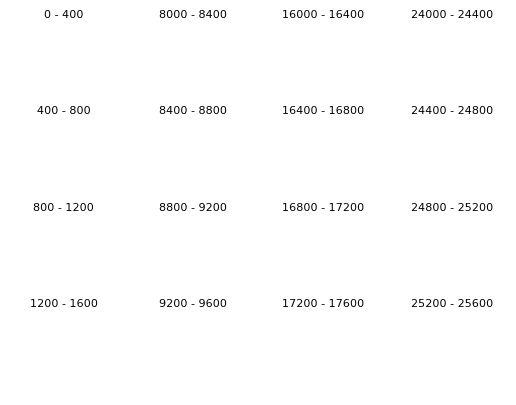

In [204]:
k = 0
l = 0
fig, axes = plt.subplots(nrows=nrows,ncols=ncols)
for row in range(nrows):
    for col in range(ncols):
        ax = axes[row,col]
        ztop_step = k*ncols + col
        zbottom_step = l*nrows + row

        # the step where we start counting from to get the counts at x and y steps
        # for a given ztop,zbottom
        step0 = ysteps*xsteps*zbottom_steps*ztop_step + zbottom_step*ysteps*xsteps
        ax.plot([],[])
        ax.set_axis_off()
        ax.set_title(f"{step0} - {step0+xsteps*ysteps}",fontsize=8)
# print(step0)

In [205]:
steps = []
for k in range(ztop_steps//ncols):
    for l in range(zbottom_steps//nrows):
        for row in range(nrows):
            for col in range(ncols):
#                 ax = axes[row,col]
                ztop_step = k*ncols + col
                zbottom_step = l*nrows + row

                # the step where we start counting from to get the counts at x and y steps
                # for a given ztop,zbottom
                step0 = ysteps*xsteps*zbottom_steps*ztop_step + zbottom_step*ysteps*xsteps
                steps.append(step0)
#                 ax.plot([],[])
#                 ax.set_axis_off()
#                 ax.set_title(f"{step0} - {step0+xsteps*ysteps}",fontsize=8)
        # print(step0)
steps = sorted(steps)

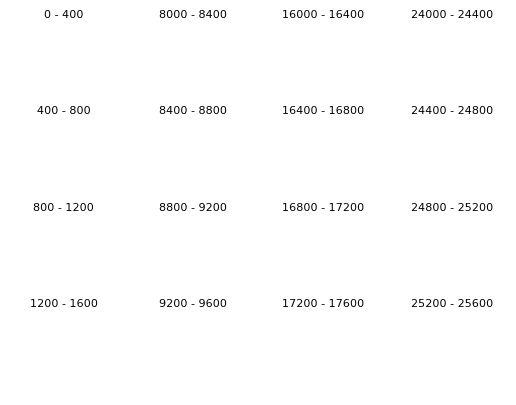

In [204]:
f
fig, axes = plt.subplots(nrows=nrows,ncols=ncols)
for row in range(nrows):
    for col in range(ncols):
        ax = axes[row,col]
        ztop_step = k*ncols + col
        zbottom_step = l*nrows + row

        # the step where we start counting from to get the counts at x and y steps
        # for a given ztop,zbottom
        step0 = ysteps*xsteps*zbottom_steps*ztop_step + zbottom_step*ysteps*xsteps
        ax.plot([],[])
        ax.set_axis_off()
        ax.set_title(f"{step0} - {step0+xsteps*ysteps}",fontsize=8)
# print(step0)

Text(0, 0.5, 'y')

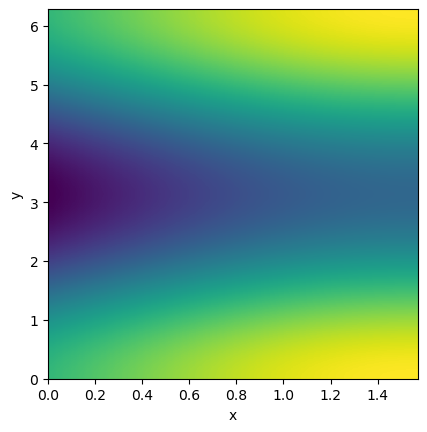

In [98]:
nx = 200
ny = 50
xpts = np.linspace(0,2*np.pi,nx)
ypts = np.linspace(0,np.pi/2,ny)
data = np.zeros(nx*ny)
step = 0
for x in xpts:
    for y in ypts:
        data[step] = np.cos(x)+np.sin(y)
        step += 1
fig,ax = plt.subplots()
ax.imshow(data.reshape((nx,ny)),extent=[ypts[0],ypts[-1],xpts[0],xpts[-1]])
ax.set_aspect((ypts[-1]-ypts[0])/(xpts[-1]-xpts[0]))
ax.set_xlabel("x")
ax.set_ylabel("y")